<a href="https://colab.research.google.com/github/punchnami/AI-Powered-Research-Query-Chatbot/blob/main/final_consolidated_SARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set-Up

## Mount Drive

In [386]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Needed Libraries

In [387]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import warnings

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss

## Define Needed Formulas

In [388]:
# Adjusted R Squared

def adjusted_r_squared(r_squared, n, k):
    return 1 - ((1 - r_squared) * ((n - 1) / (n - k - 1)))

# Data Cleaning & Merging

## Broad General Collateral Rate (BGCR) Data

In [389]:
search_file_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/1. BGCR; SOFR/Search.xlsx'
df = pd.read_excel(search_file_path)
df_cleaned = df.dropna(axis=1, how='all')
df_cleaned = df_cleaned.drop(columns=['Footnote ID'])
df_cleaned = df_cleaned[df_cleaned['Rate Type'] == 'BGCR']
df_BGCR = df_cleaned.copy()
df_BGCR = df_BGCR.rename(columns={'Effective Date': 'Date'})

## Daily Treasury Rates Data

In [390]:
d_treas_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/2 3. Treasury Yield; Yield Spread; Federal'
files_to_concatenate = [
    'daily-treasury-rates_2018.csv',
    'daily-treasury-rates_2019.csv',
    'daily-treasury-rates_2020.csv',
    'daily-treasury-rates_2021.csv',
    'daily-treasury-rates_2022.csv',
    'daily-treasury-rates_2023.csv',
    'daily-treasury-rates_2024.csv'
]
df_list = []
for file in files_to_concatenate:
    file_path = os.path.join(d_treas_path, file)
    df = pd.read_csv(file_path)
    df_list.append(df)
merged_df = pd.concat(df_list, ignore_index=True)
merged_df = merged_df.dropna(axis=1, how='all')
if 'Footnote ID' in merged_df.columns:
    merged_df = merged_df.drop(columns=['Footnote ID'])
merged_daily_treasury_rates = merged_df.copy()

## Daily Treasury Rates LT Data

In [391]:
files_to_concatenate = [
    'daily-treasury-rates_LT_2018.csv',
    'daily-treasury-rates_LT_2019.csv',
    'daily-treasury-rates_LT_2020.csv',
    'daily-treasury-rates_LT_2021.csv',
    'daily-treasury-rates_LT_2022.csv',
    'daily-treasury-rates_LT_2023.csv',
    'daily-treasury-rates_LT_2024.csv'
]
df_list = []
for file in files_to_concatenate:
    file_path = os.path.join(d_treas_path, file)
    df = pd.read_csv(file_path)
    df_list.append(df)
merged_df = pd.concat(df_list, ignore_index=True)
merged_df = merged_df.dropna(axis=1, how='all')
if 'Footnote ID' in merged_df.columns:
    merged_df = merged_df.drop(columns=['Footnote ID'])
merged_daily_treasury_LT_rates = merged_df.copy()

df_merged = pd.merge(merged_daily_treasury_rates, merged_daily_treasury_LT_rates, on='Date', how='inner')

## Feature Additions

In [392]:
# Calculate short-term yield spreads
df_merged['Yield Spread (4W - 52W)'] = df_merged['52 WEEKS COUPON EQUIVALENT'] - df_merged['4 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (13W - 52W)'] = df_merged['52 WEEKS COUPON EQUIVALENT'] - df_merged['13 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (26W - 52W)'] = df_merged['52 WEEKS COUPON EQUIVALENT'] - df_merged['26 WEEKS COUPON EQUIVALENT']

# Calculate long-term yield spreads
df_merged['Yield Spread (10Y - 4W)'] = df_merged['LT COMPOSITE (>10 Yrs)'] - df_merged['4 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (20Y - 4W)'] = df_merged['TREASURY 20-Yr CMT'] - df_merged['4 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (10Y - 52W)'] = df_merged['LT COMPOSITE (>10 Yrs)'] - df_merged['52 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (20Y - 52W)'] = df_merged['TREASURY 20-Yr CMT'] - df_merged['52 WEEKS COUPON EQUIVALENT']

## Columns to Keep

In [393]:
columns_to_keep = [
    'Date',
    '4 WEEKS COUPON EQUIVALENT',
    '13 WEEKS COUPON EQUIVALENT',
    '26 WEEKS COUPON EQUIVALENT',
    '52 WEEKS COUPON EQUIVALENT',
    'LT COMPOSITE (>10 Yrs)',
    'TREASURY 20-Yr CMT',
    'Yield Spread (4W - 52W)',
    'Yield Spread (13W - 52W)',
    'Yield Spread (26W - 52W)',
    'Yield Spread (10Y - 4W)',
    'Yield Spread (20Y - 4W)',
    'Yield Spread (10Y - 52W)',
    'Yield Spread (20Y - 52W)'
]
df_relevant = df_merged[columns_to_keep]

df_merged = pd.merge(df_BGCR, df_relevant, on='Date', how='inner')
df_merged['Date'] = pd.to_datetime(df_merged['Date'])

## Add CPI

In [394]:
cpi_data = {
    'Year': [2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'Jan': [247.867, 251.712, 257.971, 261.582, 281.148, 299.170, 308.417],
    'Feb': [248.991, 252.776, 258.678, 263.014, 283.716, 300.840, 310.326],
    'Mar': [249.554, 254.202, 258.115, 264.877, 287.504, 301.836, 312.332],
    'Apr': [250.546, 255.548, 256.389, 267.054, 289.109, 303.363, 313.548],
    'May': [251.588, 256.092, 256.934, 269.195, 292.296, 304.127, 314.069],
    'Jun': [251.988, 256.143, 257.797, 271.696, 296.311, 305.109, 314.069],
    'Jul': [252.006, 256.571, 259.101, 273.003, 296.276, 305.691, None],
    'Aug': [252.146, 256.558, 259.918, 273.567, 296.171, 307.026, None],
    'Sep': [252.439, 256.759, 260.280, 274.310, 296.908, 307.789, None],
    'Oct': [252.885, 257.346, 260.388, 276.589, 298.012, 307.671, None],
    'Nov': [252.038, 257.346, 260.229, 277.948, 297.711, 307.051, None],
    'Dec': [251.233, 257.208, 260.474, 278.802, 296.797, 306.746, None]
}


cpi_df = pd.DataFrame(cpi_data)
cpi_long_df = pd.melt(cpi_df, id_vars=['Year'], var_name='Month', value_name='CPI')
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}
cpi_long_df['Month'] = cpi_long_df['Month'].map(month_mapping)
cpi_long_df['Day'] = 1
cpi_long_df['Date'] = pd.to_datetime(cpi_long_df[['Year', 'Month', 'Day']])
cpi_long_df.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)
cpi_long_df.set_index('Date', inplace=True)
cpi_long_df = cpi_long_df.resample('D').ffill()
cpi_long_df.reset_index(inplace=True)
cpi_long_df['Date'] = pd.to_datetime(cpi_long_df['Date'])

df_merged2 = pd.merge(df_merged, cpi_long_df[['Date', 'CPI']], on='Date', how='left')

## Add SPX

In [395]:
spx_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/6. Stock Market Data/HistoricalData_1719610851813_SPX.csv'
df = pd.read_csv(spx_path)
df = df.drop(columns=['Open', 'High', 'Low'])
df = df.rename(columns={'Close/Last': 'SPX'})
df['Date'] = pd.to_datetime(df['Date'])

df_merged3 = pd.merge(df_merged2, df, on='Date', how='inner')

## Add NASDAQ

In [396]:
nasdaq_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/6. Stock Market Data/HistoricalData_1719611009685_COMP.csv'
df = pd.read_csv(nasdaq_path)
df = df.drop(columns=['Open', 'High', 'Low'])
df = df.rename(columns={'Close/Last': 'NASDAQ'})
df['Date'] = pd.to_datetime(df['Date'])

df_merged4 = pd.merge(df_merged3, df, on='Date', how='inner')

## Add DJIA

In [397]:
djia_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/6. Stock Market Data/HistoricalPrices_DJIA.csv'
df = pd.read_csv(djia_path)
df = df.drop(columns=[' Open', ' High', ' Low'], axis=1)
df = df.rename(columns={' Close': 'DJIA'})
df['Date'] = pd.to_datetime(df['Date'])

df_merged5 = pd.merge(df_merged4, df, on='Date', how='inner')

<ipython-input-397-884830d5858d>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


## Add ForEx

In [398]:
forex_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/7. FX/FRB_H10.csv'
df = pd.read_csv(forex_path)
df = df.iloc[5:]
df.rename(columns={'Series Description': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])

df_merged6 = pd.merge(df_merged5, df, on='Date', how='inner')

# Model 1: ARIMAX With Initial Features

## Initial Feature Set

In [399]:
df_model_v1 = df_merged6.copy()
df_model_v1 = df_model_v1.drop(columns=[ 'Rate Type','1st Percentile (%)', '25th Percentile (%)', '75th Percentile (%)', '99th Percentile (%)',
                                  '4 WEEKS COUPON EQUIVALENT', '13 WEEKS COUPON EQUIVALENT', '26 WEEKS COUPON EQUIVALENT', '52 WEEKS COUPON EQUIVALENT'])

# Set the 'Date' column as the index
df_model_v1.set_index('Date', inplace=True)
df_model_v1 = df_model_v1.sort_index(ascending=True)
df_model_v1

# Replace 'ND' with NaN and fill with a method or drop rows
df_model_v1.replace('ND', np.nan, inplace=True)

print("NaN values in original features dataframe before dropping:")
print(df_model_v1.isna().sum())

# Drop rows with NaN values in the dataframe
df_model_v1.dropna(inplace=True)

cols = ['SPOT EXCHANGE RATE - EURO AREA ', 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)', 'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. ', 'JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ']
df_model_v1[cols] = df_model_v1[cols].astype(float)

# Re-check for any remaining NaN values
print("\n\nNaN values in original features dataframe after dropping:")
print(df_model_v1.isna().sum())

NaN values in original features dataframe before dropping:
Rate (%)                                                          0
Volume ($Billions)                                                0
LT COMPOSITE (>10 Yrs)                                            0
TREASURY 20-Yr CMT                                                0
Yield Spread (4W - 52W)                                           0
Yield Spread (13W - 52W)                                          0
Yield Spread (26W - 52W)                                          0
Yield Spread (10Y - 4W)                                           0
Yield Spread (20Y - 4W)                                           0
Yield Spread (10Y - 52W)                                          0
Yield Spread (20Y - 52W)                                          0
CPI                                                               0
SPX                                                               0
NASDAQ                                                   

## Training

In [400]:
# Split into train and test

train_v1 = df_model_v1[:'2022-12-31']
test_v1 = df_model_v1['2023-01-01':]

# Split into X & y

y_train_v1 = train_v1['Rate (%)']
X_train_v1 = train_v1.drop(columns=['Rate (%)'])
y_test_v1 = test_v1['Rate (%)']
X_test_v1 = test_v1.drop(columns=['Rate (%)'])

# Scaling values

scaler = MinMaxScaler()
X_train_v1_scaled = scaler.fit_transform(X_train_v1)
X_test_v1_scaled = scaler.transform(X_test_v1)

# model definition

model_v1 = SARIMAX(y_train_v1, exog= X_train_v1_scaled, order= (1,1,1), seasonal_order= (0,0,0,0)) # order was (1,1,1) seasonal_order was (0,0,0,0)
model_v1_fit = model_v1.fit(disp=False)
print(model_v1_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:               Rate (%)   No. Observations:                 1181
Model:               SARIMAX(1, 1, 1)   Log Likelihood            -6906784.849
Date:                Sun, 18 Aug 2024   AIC                       13813611.699
Time:                        04:17:57   BIC                       13813718.237
Sample:                             0   HQIC                      13813651.864
                               - 1181                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1672   1.62e-05   1.03e+04      0.000       0.167       0.167
x2           3.93e+13   5.79e-06   6.79e+18      0.000    3.93e+13    3.93e+13
x3         -4.061e+13   5.45e-06  -7.46e+18      0.0

## Testing

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


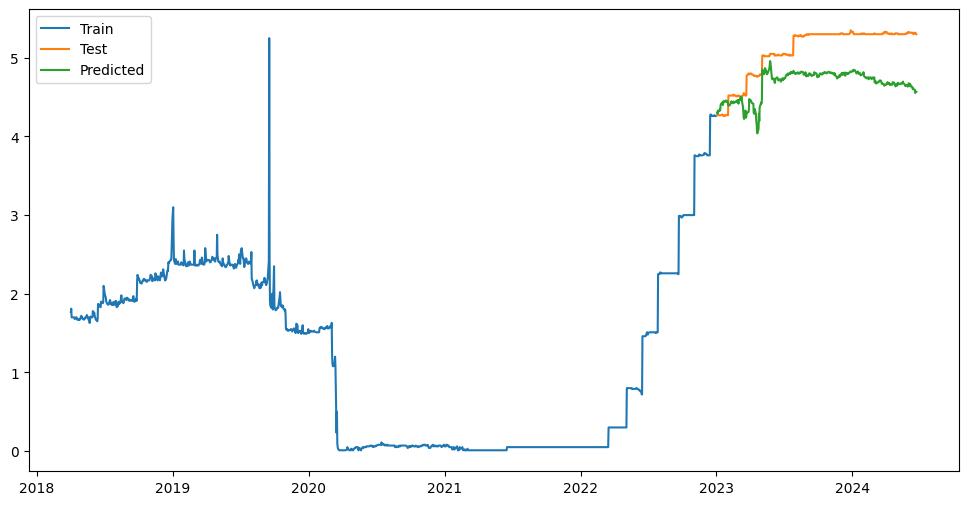

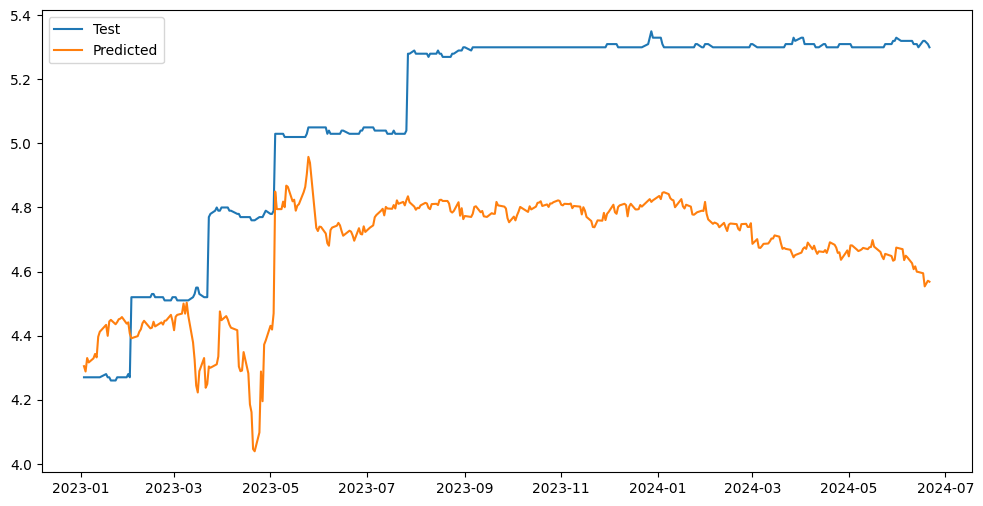

Mean Squared Error: 0.2245
Mean Absolute Error: 0.4356
R2 Score: -1.1521
Root Mean Squared Error: 0.4738
Adjusted R-squared: -1.2634


In [401]:
# Predict using the test set
y_pred_v1 = model_v1_fit.predict(start=len(y_train_v1), end=len(y_train_v1) + len(y_test_v1) - 1, exog=X_test_v1_scaled)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_train_v1.index, y_train_v1, label='Train')
plt.plot(y_test_v1.index, y_test_v1, label='Test')
plt.plot(y_test_v1.index, y_pred_v1, label='Predicted')
plt.legend()
plt.show()

print("\n\n")

plt.figure(figsize=(12, 6))
plt.plot(y_test_v1.index, y_test_v1, label='Test')
plt.plot(y_test_v1.index, y_pred_v1, label='Predicted')
plt.legend()
plt.show()

# Calculate mean squared error
mse = mean_squared_error(y_test_v1, y_pred_v1)
mae = mean_absolute_error(y_test_v1, y_pred_v1)
rsquare = r2_score(y_test_v1, y_pred_v1)
rmse = np.sqrt(mse)
n = len(y_test_v1) # number of rows/observations
k = len(X_test_v1_scaled[0]) # number of independent variables/features
arsquare = adjusted_r_squared(rsquare, n, k)

# Print the evaluation metrics
print(f'Mean Squared Error: {round(mse,4)}')
print(f'Mean Absolute Error: {round(mae,4)}')
print(f'R2 Score: {round(rsquare,4)}')
print(f'Root Mean Squared Error: {round(rmse,4)}')
print(f'Adjusted R-squared: {round(arsquare,4)}')

# Model 2: ARIMAX With Additional Features

## Add PPI

In [402]:
ppi_data = {
    'Year': [2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'Jan': [114.8, 117, 119.3, 121.2, 133.576, 141.286, 142.683],
    'Feb': [115.1, 117.2, 118.6, 122, 134.821, 141.237, 143.509],
    'Mar': [115.3, 117.6, 118, 122.8, 137.041, 140.738, 143.410],
    'Apr': [115.5, 118.2, 116.6, 124.1, 137.805, 140.977, 144.119],
    'May': [115.9, 118.3, 117.2, 125.3, 139.026, 140.664, 144.079],
    'Jun': [116.3, 118.2, 117.5, 126.2, 140.238, 140.672, 144.402],
    'Jul': [116.4, 118.5, 118.2, 127.504, 139.837, 141.461, None],
    'Aug': [116.5, 118.6, 118.4, 128.574, 139.721, 142.353, None],
    'Sep': [116.7, 118.3, 118.7, 129.188, 140.137, 142.658, None],
    'Oct': [117.5, 118.8, 119.4, 130.061, 140.666, 142.191, None],
    'Nov': [117.4, 118.6, 119.5, 131.455, 141.18, 142.267, None],
    'Dec': [117.4, 119, 120, 132.224, 140.696, 142.17, None]
}

# Converting PPI data to DataFrame
ppi_df = pd.DataFrame(ppi_data)

# Melting the PPI DataFrame to long format
ppi_long_df = pd.melt(ppi_df, id_vars=['Year'], var_name='Month', value_name='PPI')

# Mapping month names to numbers
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}
ppi_long_df['Month'] = ppi_long_df['Month'].map(month_mapping)

# Creating a 'Day' column with value 1 for each row
ppi_long_df['Day'] = 1

# Creating a date column in the PPI DataFrame
ppi_long_df['Date'] = pd.to_datetime(ppi_long_df[['Year', 'Month', 'Day']])

# Dropping unnecessary columns
ppi_long_df.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)

# Setting the Date as the index
ppi_long_df.set_index('Date', inplace=True)

# Reindexing to fill in missing dates with forward fill for the last known PPI value of each month
ppi_long_df = ppi_long_df.resample('D').ffill()

# Reset the index to have Date as a column again
ppi_long_df.reset_index(inplace=True)

ppi_long_df['Date'] = pd.to_datetime(ppi_long_df['Date'])
df_merged7 = pd.merge(df_merged6, ppi_long_df[['Date', 'PPI']], on='Date', how='inner')

## Add Unemployment

In [403]:
unemp_data = {
    'Year': [2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'Jan': [4, 4, 3.6, 6.4, 4, 3.4, 3.7],
    'Feb': [4.1, 3.8, 3.5, 6.2, 3.8, 3.6, 3.9],
    'Mar': [4, 3.8, 4.4, 6.1, 3.6, 3.5, 3.8],
    'Apr': [4, 3.7, 14.8, 6.1, 3.7, 3.4, 3.9],
    'May': [3.8, 3.6, 13.2, 5.8, 3.6, 3.7, 4],
    'Jun': [4, 3.6, 11, 5.9, 3.6, 3.6, 4.1],
    'Jul': [3.8, 3.7, 10.2, 5.4, 3.5, 3.5, None],
    'Aug': [3.8, 3.6, 8.4, 5.1, 3.6, 3.8, None],
    'Sep': [3.7, 3.5, 7.8, 4.7, 3.5, 3.8, None],
    'Oct': [3.8, 3.6, 6.8, 4.5, 3.6, 3.8, None],
    'Nov': [3.8, 3.6, 6.7, 4.1, 3.6, 3.7, None],
    'Dec': [3.9, 3.6, 6.7, 3.9, 3.5, 3.7, None]
}

# Converting Unempl data to DataFrame
unemp_df = pd.DataFrame(unemp_data)

# Melting the Unempl DataFrame to long format
unemp_long_df = pd.melt(unemp_df, id_vars=['Year'], var_name='Month', value_name='Unemployment')

# Maunempng month names to numbers
month_maunempng = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}
unemp_long_df['Month'] = unemp_long_df['Month'].map(month_maunempng)

# Creating a 'Day' column with value 1 for each row
unemp_long_df['Day'] = 1

# Creating a date column in the Unempl DataFrame
unemp_long_df['Date'] = pd.to_datetime(unemp_long_df[['Year', 'Month', 'Day']])

# Drounempng unnecessary columns
unemp_long_df.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)

# Setting the Date as the index
unemp_long_df.set_index('Date', inplace=True)

# Reindexing to fill in missing dates with forward fill for the last known Unempl value of each month
unemp_long_df = unemp_long_df.resample('D').ffill()

# Reset the index to have Date as a column again
unemp_long_df.reset_index(inplace=True)

unemp_long_df['Date'] = pd.to_datetime(unemp_long_df['Date'])
df_merged8 = pd.merge(df_merged7, unemp_long_df[['Date', 'Unemployment']], on='Date', how='inner')

## V2 Feature Set

In [404]:
df_model_v2 = df_merged8.copy()
df_model_v2 = df_model_v2.drop(columns=[ 'Rate Type','1st Percentile (%)', '25th Percentile (%)', '75th Percentile (%)', '99th Percentile (%)',
                                  '4 WEEKS COUPON EQUIVALENT', '13 WEEKS COUPON EQUIVALENT', '26 WEEKS COUPON EQUIVALENT', '52 WEEKS COUPON EQUIVALENT'])

# Set the 'Date' column as the index
df_model_v2.set_index('Date', inplace=True)
df_model_v2 = df_model_v2.sort_index(ascending=True)
df_model_v2

# Replace 'ND' with NaN and fill with a method or drop rows
df_model_v2.replace('ND', np.nan, inplace=True)

print("NaN values in original features dataframe before dropping:")
print(df_model_v2.isna().sum())

# Drop rows with NaN values in the dataframe
df_model_v2.dropna(inplace=True)

cols = ['SPOT EXCHANGE RATE - EURO AREA ', 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)', 'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. ', 'JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ']
df_model_v2[cols] = df_model_v2[cols].astype(float)

# Re-check for any remaining NaN values
print("\n\nNaN values in original features dataframe after dropping:")
print(df_model_v2.isna().sum())

NaN values in original features dataframe before dropping:
Rate (%)                                                          0
Volume ($Billions)                                                0
LT COMPOSITE (>10 Yrs)                                            0
TREASURY 20-Yr CMT                                                0
Yield Spread (4W - 52W)                                           0
Yield Spread (13W - 52W)                                          0
Yield Spread (26W - 52W)                                          0
Yield Spread (10Y - 4W)                                           0
Yield Spread (20Y - 4W)                                           0
Yield Spread (10Y - 52W)                                          0
Yield Spread (20Y - 52W)                                          0
CPI                                                               0
SPX                                                               0
NASDAQ                                                   

## Training

In [405]:
# Split into train and test

train_v2 = df_model_v2[:'2022-12-31']
test_v2 = df_model_v2['2023-01-01':]

# Split into X & y

y_train_v2 = train_v2['Rate (%)']
X_train_v2 = train_v2.drop(columns=['Rate (%)'])
y_test_v2 = test_v2['Rate (%)']
X_test_v2 = test_v2.drop(columns=['Rate (%)'])

# Scaling values

scaler = MinMaxScaler()
X_train_v2_scaled = scaler.fit_transform(X_train_v2)
X_test_v2_scaled = scaler.transform(X_test_v2)

# model definition

model_v2 = SARIMAX(y_train_v2, exog= X_train_v2_scaled, order= (1,1,1), seasonal_order= (0,0,0,0)) # order was (1,1,1) seasonal_order was (0,0,0,0)
model_v2_fit = model_v2.fit(disp=False)
print(model_v2_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               Rate (%)   No. Observations:                 1181
Model:               SARIMAX(1, 1, 1)   Log Likelihood           -12781182.832
Date:                Sun, 18 Aug 2024   AIC                       25562411.665
Time:                        04:18:10   BIC                       25562528.350
Sample:                             0   HQIC                      25562455.656
                               - 1181                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1751   4.07e-05   4303.335      0.000       0.175       0.175
x2          3.783e+13   9.64e-06   3.92e+18      0.000    3.78e+13    3.78e+13
x3         -3.909e+13   8.73e-06  -4.48e+18      0.0

## Testing

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


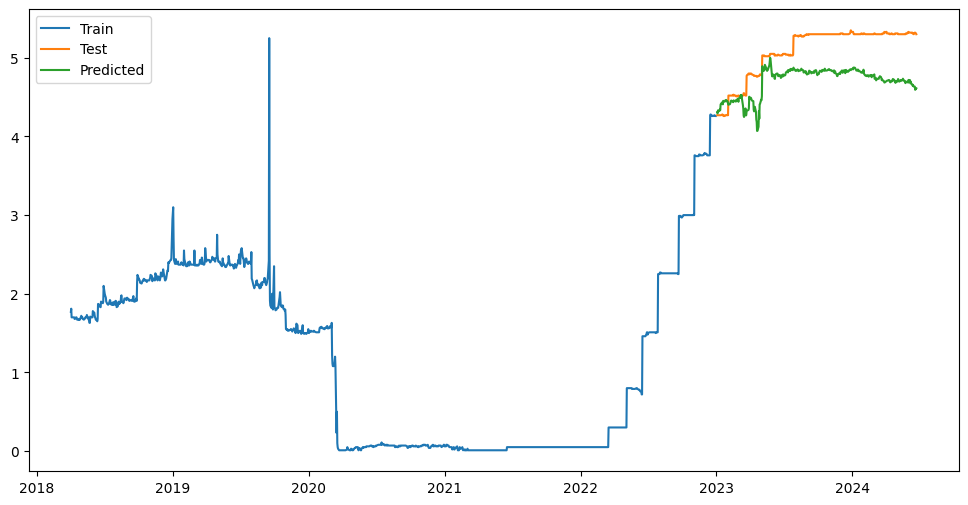

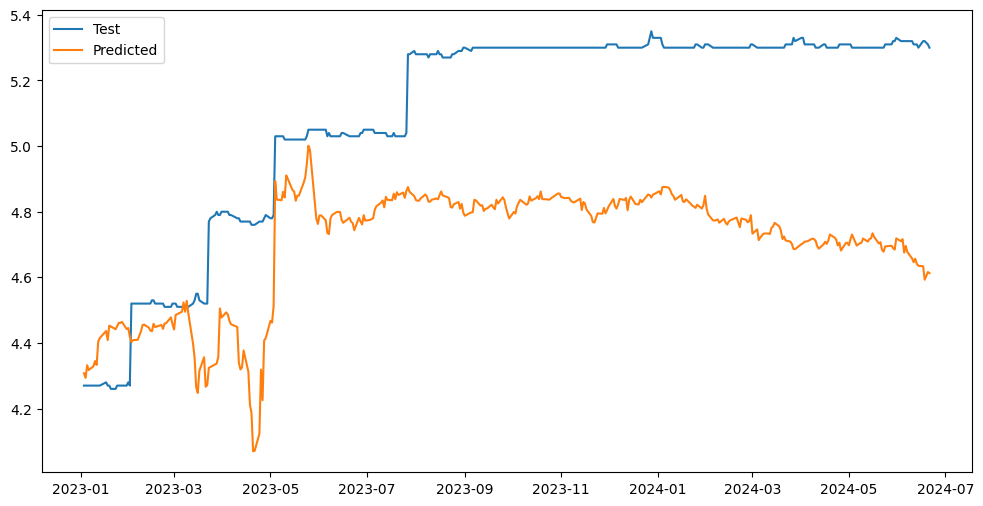

Mean Squared Error: 0.1956
Mean Absolute Error: 0.4038
R2 Score: -0.8758
Root Mean Squared Error: 0.4423
Adjusted R-squared: -0.9842


In [406]:
# Predict using the test set
y_pred_v2 = model_v2_fit.predict(start=len(y_train_v2), end=len(y_train_v2) + len(y_test_v2) - 1, exog=X_test_v2_scaled)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_train_v2.index, y_train_v2, label='Train')
plt.plot(y_test_v2.index, y_test_v2, label='Test')
plt.plot(y_test_v2.index, y_pred_v2, label='Predicted')
plt.legend()
plt.show()

print("\n\n")

plt.figure(figsize=(12, 6))
plt.plot(y_test_v2.index, y_test_v2, label='Test')
plt.plot(y_test_v2.index, y_pred_v2, label='Predicted')
plt.legend()
plt.show()

# Calculate mean squared error
mse = mean_squared_error(y_test_v2, y_pred_v2)
mae = mean_absolute_error(y_test_v2, y_pred_v2)
rsquare = r2_score(y_test_v2, y_pred_v2)
rmse = np.sqrt(mse)
n = len(y_test_v2) # number of rows/observations
k = len(X_test_v2_scaled[0]) # number of independent variables/features
arsquare = adjusted_r_squared(rsquare, n, k)

# Print the evaluation metrics
print(f'Mean Squared Error: {round(mse,4)}')
print(f'Mean Absolute Error: {round(mae,4)}')
print(f'R2 Score: {round(rsquare,4)}')
print(f'Root Mean Squared Error: {round(rmse,4)}')
print(f'Adjusted R-squared: {round(arsquare,4)}')

# Model 3: SARIMAX Model

## Re-introducing V2 Feature Set as V3

In [407]:
df_model_v3 = df_merged8.copy()
df_model_v3 = df_model_v3.drop(columns=[ 'Rate Type','1st Percentile (%)', '25th Percentile (%)', '75th Percentile (%)', '99th Percentile (%)',
                                  '4 WEEKS COUPON EQUIVALENT', '13 WEEKS COUPON EQUIVALENT', '26 WEEKS COUPON EQUIVALENT', '52 WEEKS COUPON EQUIVALENT'])

# Set the 'Date' column as the index
df_model_v3.set_index('Date', inplace=True)
df_model_v3 = df_model_v3.sort_index(ascending=True)
df_model_v3

# Replace 'ND' with NaN and fill with a method or drop rows
df_model_v3.replace('ND', np.nan, inplace=True)

print("NaN values in original features dataframe before dropping:")
print(df_model_v3.isna().sum())

# Drop rows with NaN values in the dataframe
df_model_v3.dropna(inplace=True)

cols = ['SPOT EXCHANGE RATE - EURO AREA ', 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)', 'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. ', 'JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ']
df_model_v3[cols] = df_model_v3[cols].astype(float)

# Re-check for any remaining NaN values
print("\n\nNaN values in original features dataframe after dropping:")
print(df_model_v3.isna().sum())

NaN values in original features dataframe before dropping:
Rate (%)                                                          0
Volume ($Billions)                                                0
LT COMPOSITE (>10 Yrs)                                            0
TREASURY 20-Yr CMT                                                0
Yield Spread (4W - 52W)                                           0
Yield Spread (13W - 52W)                                          0
Yield Spread (26W - 52W)                                          0
Yield Spread (10Y - 4W)                                           0
Yield Spread (20Y - 4W)                                           0
Yield Spread (10Y - 52W)                                          0
Yield Spread (20Y - 52W)                                          0
CPI                                                               0
SPX                                                               0
NASDAQ                                                   

## Checking for Seasonality

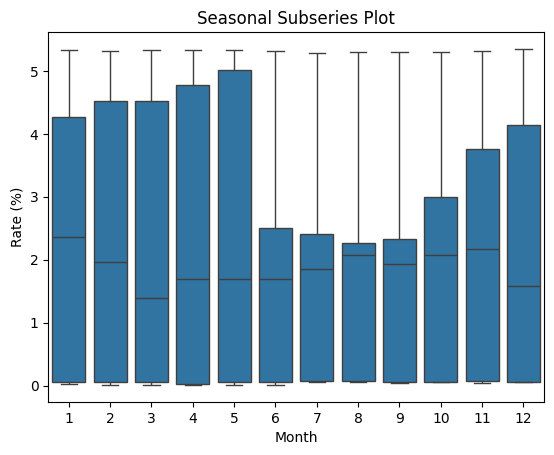

In [408]:
df_seasons= df_model_v3.copy()

df_seasons['Month'] = df_seasons.index.month
sns.boxplot(x='Month', y='Rate (%)', data=df_seasons.reset_index())
plt.title('Seasonal Subseries Plot')
plt.xlabel('Month')
plt.ylabel('Rate (%)')
plt.show()

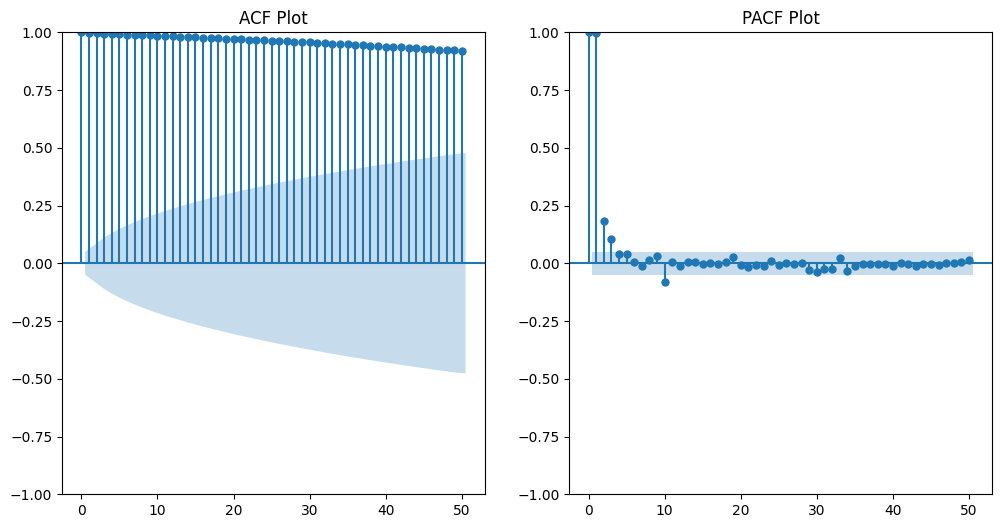

In [409]:
# Autocorrelation Function (ACF) Plot

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_acf(df_seasons['Rate (%)'], lags=50, ax=plt.gca())
plt.title('ACF Plot')

#  Partial Autocorrelation Function (PACF)

plt.subplot(1, 2, 2)
plot_pacf(df_seasons['Rate (%)'], lags=50, ax=plt.gca())
plt.title('PACF Plot')
plt.show()

In [410]:
# Ljung-Box Test

from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(df_seasons['Rate (%)'], lags=[12], return_df=True)
print(lb_test)

         lb_stat  lb_pvalue
12  18284.584561        0.0


## Training

In [411]:
# Split into train and test

train_v3 = df_model_v3[:'2022-12-31']
test_v3 = df_model_v3['2023-01-01':]

# Split into X & y

y_train_v3 = train_v3['Rate (%)']
X_train_v3 = train_v3.drop(columns=['Rate (%)'])
y_test_v3 = test_v3['Rate (%)']
X_test_v3 = test_v3.drop(columns=['Rate (%)'])

# Scaling values

scaler = MinMaxScaler()
X_train_v3_scaled = scaler.fit_transform(X_train_v3)
X_test_v3_scaled = scaler.transform(X_test_v3)

# model definition

model_v3 = SARIMAX(y_train_v3, exog= X_train_v3_scaled, order= (0,1,0), seasonal_order= (1,1,2,6))
model_v3_fit = model_v3.fit(disp=False)
print(model_v3_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                       SARIMAX Results                                        
Dep. Variable:                               Rate (%)   No. Observations:                 1181
Model:             SARIMAX(0, 1, 0)x(1, 1, [1, 2], 6)   Log Likelihood                 666.024
Date:                                Sun, 18 Aug 2024   AIC                          -1284.048
Time:                                        04:19:21   BIC                          -1162.412
Sample:                                             0   HQIC                         -1238.179
                                               - 1181                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1653      0.163      1.016      0.309      -0.153       0.484
x2 

## Testing

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


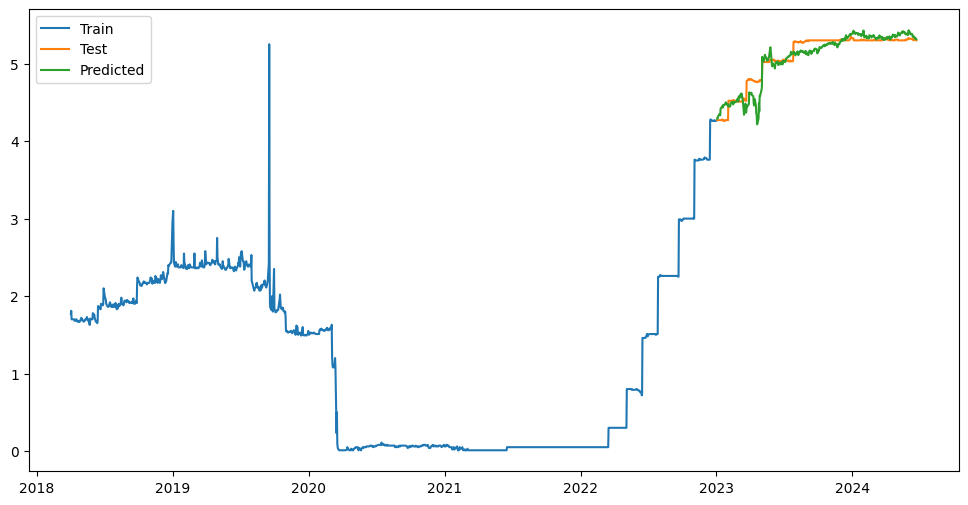

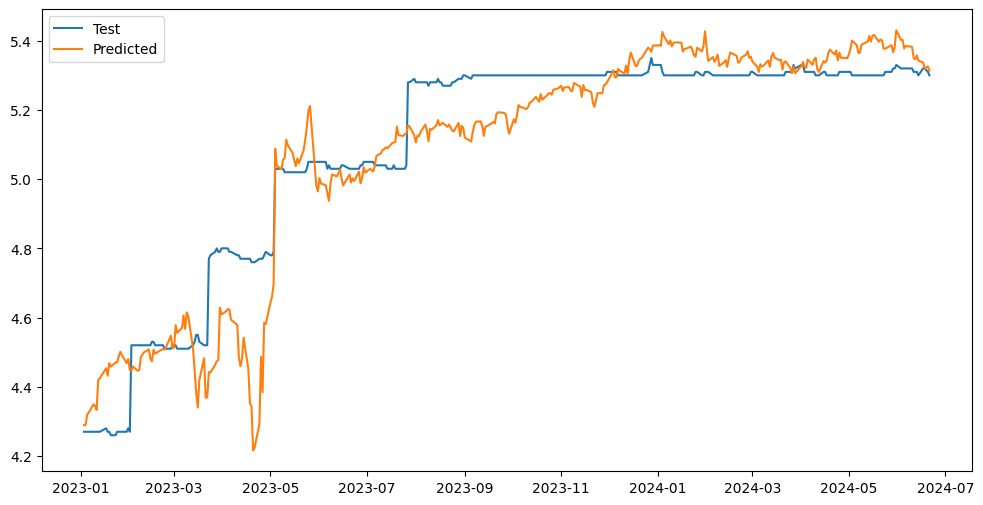

Mean Squared Error: 0.0144
Mean Absolute Error: 0.0881
R2 Score: 0.8624
Root Mean Squared Error: 0.1198
Adjusted R-squared: 0.8544


In [412]:
# Predict using the test set
y_pred_v3 = model_v3_fit.predict(start=len(y_train_v3), end=len(y_train_v3) + len(y_test_v3) - 1, exog=X_test_v3_scaled)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_train_v3.index, y_train_v3, label='Train')
plt.plot(y_test_v3.index, y_test_v3, label='Test')
plt.plot(y_test_v3.index, y_pred_v3, label='Predicted')
plt.legend()
plt.show()

print("\n\n")

plt.figure(figsize=(12, 6))
plt.plot(y_test_v3.index, y_test_v3, label='Test')
plt.plot(y_test_v3.index, y_pred_v3, label='Predicted')
plt.legend()
plt.show()

# Calculate mean squared error
mse = mean_squared_error(y_test_v3, y_pred_v3)
mae = mean_absolute_error(y_test_v3, y_pred_v3)
rsquare = r2_score(y_test_v3, y_pred_v3)
rmse = np.sqrt(mse)
n = len(y_test_v3) # number of rows/observations
k = len(X_test_v3_scaled[0]) # number of independent variables/features
arsquare = adjusted_r_squared(rsquare, n, k)

# Print the evaluation metrics
print(f'Mean Squared Error: {round(mse,4)}')
print(f'Mean Absolute Error: {round(mae,4)}')
print(f'R2 Score: {round(rsquare,4)}')
print(f'Root Mean Squared Error: {round(rmse,4)}')
print(f'Adjusted R-squared: {round(arsquare,4)}')

# Model 4: SARIMAX Model with Lag and Difference Features

## Functions to check for Stationarity

### Augmented Dickey Fuller (“ADF”) test

In [413]:
def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out['Critical Value (%s)' % key] = value
    print(f'===Augmented Dickey-Fuller Test: {title}===')
    print(out.to_string())
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary")

### Kwiatkowski-Phillips-Schmidt-Shin (“KPSS”) test

In [414]:
def kpss_test(series, title=''):
    result = kpss(series.dropna(), regression='c')
    labels = ['KPSS Test Statistic', 'p-value', '#Lags Used']
    out = pd.Series(result[0:3], index=labels)
    for key, value in result[3].items():
        out['Critical Value (%s)' % key] = value
    print(f'===KPSS Test: {title}===')
    print(out.to_string())
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary")
    else:
        print("Weak evidence against the null hypothesis, time series is stationary")

## Re-introducing V2 Feature Set as V4

In [415]:
df_model_v4 = df_merged8.copy()
df_model_v4 = df_model_v4.drop(columns=[ 'Rate Type','1st Percentile (%)', '25th Percentile (%)', '75th Percentile (%)', '99th Percentile (%)',
                                  '4 WEEKS COUPON EQUIVALENT', '13 WEEKS COUPON EQUIVALENT', '26 WEEKS COUPON EQUIVALENT', '52 WEEKS COUPON EQUIVALENT'])

# Set the 'Date' column as the index
df_model_v4.set_index('Date', inplace=True)
df_model_v4 = df_model_v4.sort_index(ascending=True)
df_model_v4

# Replace 'ND' with NaN and fill with a method or drop rows
df_model_v4.replace('ND', np.nan, inplace=True)

print("NaN values in original features dataframe before dropping:")
print(df_model_v4.isna().sum())

# Drop rows with NaN values in the dataframe
df_model_v4.dropna(inplace=True)

cols = ['SPOT EXCHANGE RATE - EURO AREA ', 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)', 'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. ', 'JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ']
df_model_v4[cols] = df_model_v4[cols].astype(float)

# Re-check for any remaining NaN values
print("\n\nNaN values in original features dataframe after dropping:")
print(df_model_v4.isna().sum())

NaN values in original features dataframe before dropping:
Rate (%)                                                          0
Volume ($Billions)                                                0
LT COMPOSITE (>10 Yrs)                                            0
TREASURY 20-Yr CMT                                                0
Yield Spread (4W - 52W)                                           0
Yield Spread (13W - 52W)                                          0
Yield Spread (26W - 52W)                                          0
Yield Spread (10Y - 4W)                                           0
Yield Spread (20Y - 4W)                                           0
Yield Spread (10Y - 52W)                                          0
Yield Spread (20Y - 52W)                                          0
CPI                                                               0
SPX                                                               0
NASDAQ                                                   

## Stationarity Checks

In [416]:
df_stationary = df_model_v4.copy()

# Function to check stationarity and apply differencing
def ensure_stationarity(series, name):
    try:
        print(f"\nChecking stationarity for {name}:\n")
        adf_test(series, title=name)
        print("\n")
        kpss_test(series, title=name)

        # Check stationarity after the first differencing if necessary
        if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
            print(f"\n{name} is not stationary. Applying first differencing.\n")
            series = series.diff().dropna()

            # Ensure no infinite or NaN values
            if np.isinf(series).any() or series.isna().any():
                series.replace([np.inf, -np.inf], np.nan, inplace=True)
                series.dropna(inplace=True)

            print(f"\nRe-checking stationarity for {name} after first differencing:\n")
            adf_test(series, title=f"{name} - First Differenced")
            print("\n")
            kpss_test(series, title=f"{name} - First Differenced")

            # Check stationarity after the second differencing if necessary
            if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
                print(f"\n{name} is still not stationary. Applying second differencing.\n")
                series = series.diff().dropna()

                # Ensure no infinite or NaN values
                if np.isinf(series).any() or series.isna().any():
                    series.replace([np.inf, -np.inf], np.nan, inplace=True)
                    series.dropna(inplace=True)

                print(f"\nRe-checking stationarity for {name} after second differencing:\n")
                adf_test(series, title=f"{name} - Second Differenced")
                print("\n")
                kpss_test(series, title=f"{name} - Second Differenced")
            else:
                print(f"\n{name} is stationary after first differencing.\n")
        else:
            print(f"{name} is already stationary.\n")
    except Exception as e:
        print(f"An error occurred while processing {name}: {e}")

    return series

# Apply the function to each explanatory variable
for col in df_stationary.columns:
    if col not in ['Rate (%)', 'Rate (%) - First Differenced', 'Rate (%) - Second Differenced']:
        df_stationary[col] = ensure_stationarity(df_model_v4[col], col)

# Now, let's ensure the 'Rate (%)' column is also stationary, applying the same procedure
df_stationary['Rate (%)'] = ensure_stationarity(df_model_v4['Rate (%)'], 'Rate (%)')

print("Stationarity check and differencing completed.")


Checking stationarity for Volume ($Billions):

===Augmented Dickey-Fuller Test: Volume ($Billions)===
ADF Test Statistic                0.776581
p-value                           0.991249
#Lags Used                       13.000000
Number of Observations Used    1534.000000
Critical Value (1%)              -3.434620
Critical Value (5%)              -2.863426
Critical Value (10%)             -2.567774
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Volume ($Billions)===
KPSS Test Statistic       2.145532
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

Volume ($Billions) is not stationary. Applying first differencing.


Re-checking stationarity for Volume ($Billi

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: Volume ($Billions) - First Differenced===
ADF Test Statistic            -1.265209e+01
p-value                        1.361381e-23
#Lags Used                     1.200000e+01
Number of Observations Used    1.534000e+03
Critical Value (1%)           -3.434620e+00
Critical Value (5%)           -2.863426e+00
Critical Value (10%)          -2.567774e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Volume ($Billions) - First Differenced===
KPSS Test Statistic       0.381913
p-value                   0.084951
#Lags Used               21.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null hypothesis, time series is stationary

Volume ($Billions) is stationary after first differencing.


Checking stationarity for LT COMPOSITE (>10 Yrs):

===Augmented Dickey

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: LT COMPOSITE (>10 Yrs) - First Differenced===
ADF Test Statistic              -29.642217
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    1545.000000
Critical Value (1%)              -3.434590
Critical Value (5%)              -2.863413
Critical Value (10%)             -2.567767
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: LT COMPOSITE (>10 Yrs) - First Differenced===
KPSS Test Statistic      0.312068
p-value                  0.100000
#Lags Used               1.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Weak evidence against the null hypothesis, time series is stationary

LT COMPOSITE (>10 Yrs) is stationary after first differencing.


Checking stationarity for TREASURY 20-Yr CMT:



<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-416-a866437447eb>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:


===Augmented Dickey-Fuller Test: TREASURY 20-Yr CMT===
ADF Test Statistic               -0.307270
p-value                           0.924468
#Lags Used                        2.000000
Number of Observations Used    1545.000000
Critical Value (1%)              -3.434590
Critical Value (5%)              -2.863413
Critical Value (10%)             -2.567767
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: TREASURY 20-Yr CMT===
KPSS Test Statistic       3.25098
p-value                   0.01000
#Lags Used               25.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

TREASURY 20-Yr CMT is not stationary. Applying first differencing.


Re-checking stationarity for TREASURY 20-Yr CMT after first differencing:



<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: TREASURY 20-Yr CMT - First Differenced===
ADF Test Statistic              -29.726862
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    1545.000000
Critical Value (1%)              -3.434590
Critical Value (5%)              -2.863413
Critical Value (10%)             -2.567767
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: TREASURY 20-Yr CMT - First Differenced===
KPSS Test Statistic      0.311121
p-value                  0.100000
#Lags Used               0.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Weak evidence against the null hypothesis, time series is stationary

TREASURY 20-Yr CMT is stationary after first differencing.


Checking stationarity for Yield Spread (4W - 52W):



<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-416-a866437447eb>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:


===Augmented Dickey-Fuller Test: Yield Spread (4W - 52W)===
ADF Test Statistic               -1.761954
p-value                           0.399507
#Lags Used                       23.000000
Number of Observations Used    1524.000000
Critical Value (1%)              -3.434648
Critical Value (5%)              -2.863438
Critical Value (10%)             -2.567781
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Yield Spread (4W - 52W)===
KPSS Test Statistic       0.552794
p-value                   0.029776
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

Yield Spread (4W - 52W) is not stationary. Applying first differencing.


Re-checking stationarity for Yield Spread (4W - 52W) after first differencin

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-416-a866437447eb>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:


===Augmented Dickey-Fuller Test: Yield Spread (13W - 52W)===
ADF Test Statistic               -1.765429
p-value                           0.397755
#Lags Used                       23.000000
Number of Observations Used    1524.000000
Critical Value (1%)              -3.434648
Critical Value (5%)              -2.863438
Critical Value (10%)             -2.567781
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Yield Spread (13W - 52W)===
KPSS Test Statistic       0.551603
p-value                   0.030044
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

Yield Spread (13W - 52W) is not stationary. Applying first differencing.


Re-checking stationarity for Yield Spread (13W - 52W) after first differe

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-416-a866437447eb>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:


===Augmented Dickey-Fuller Test: Yield Spread (26W - 52W)===
ADF Test Statistic               -1.797696
p-value                           0.381606
#Lags Used                       23.000000
Number of Observations Used    1524.000000
Critical Value (1%)              -3.434648
Critical Value (5%)              -2.863438
Critical Value (10%)             -2.567781
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Yield Spread (26W - 52W)===
KPSS Test Statistic       1.076525
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

Yield Spread (26W - 52W) is not stationary. Applying first differencing.


Re-checking stationarity for Yield Spread (26W - 52W) after first differe

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: Yield Spread (26W - 52W) - First Differenced===
ADF Test Statistic            -8.362724e+00
p-value                        2.795353e-13
#Lags Used                     2.200000e+01
Number of Observations Used    1.524000e+03
Critical Value (1%)           -3.434648e+00
Critical Value (5%)           -2.863438e+00
Critical Value (10%)          -2.567781e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Yield Spread (26W - 52W) - First Differenced===
KPSS Test Statistic       0.065045
p-value                   0.100000
#Lags Used               20.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null hypothesis, time series is stationary

Yield Spread (26W - 52W) is stationary after first differencing.


Checking stationarity for Yield Spread (10Y - 4W):



<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-416-a866437447eb>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:


===Augmented Dickey-Fuller Test: Yield Spread (10Y - 4W)===
ADF Test Statistic               -0.991309
p-value                           0.756421
#Lags Used                       24.000000
Number of Observations Used    1523.000000
Critical Value (1%)              -3.434651
Critical Value (5%)              -2.863440
Critical Value (10%)             -2.567781
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Yield Spread (10Y - 4W)===
KPSS Test Statistic       1.74669
p-value                   0.01000
#Lags Used               25.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

Yield Spread (10Y - 4W) is not stationary. Applying first differencing.


Re-checking stationarity for Yield Spread (10Y - 4W) after first differencing:



<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: Yield Spread (10Y - 4W) - First Differenced===
ADF Test Statistic            -8.381766e+00
p-value                        2.499047e-13
#Lags Used                     2.300000e+01
Number of Observations Used    1.523000e+03
Critical Value (1%)           -3.434651e+00
Critical Value (5%)           -2.863440e+00
Critical Value (10%)          -2.567781e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Yield Spread (10Y - 4W) - First Differenced===
KPSS Test Statistic       0.133822
p-value                   0.100000
#Lags Used               17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null hypothesis, time series is stationary

Yield Spread (10Y - 4W) is stationary after first differencing.


Checking stationarity for Yield Spread (20Y - 4W):



<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-416-a866437447eb>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:


===Augmented Dickey-Fuller Test: Yield Spread (20Y - 4W)===
ADF Test Statistic               -0.999176
p-value                           0.753565
#Lags Used                       24.000000
Number of Observations Used    1523.000000
Critical Value (1%)              -3.434651
Critical Value (5%)              -2.863440
Critical Value (10%)             -2.567781
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Yield Spread (20Y - 4W)===
KPSS Test Statistic       1.579764
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

Yield Spread (20Y - 4W) is not stationary. Applying first differencing.


Re-checking stationarity for Yield Spread (20Y - 4W) after first differencin

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: Yield Spread (20Y - 4W) - First Differenced===
ADF Test Statistic            -8.370157e+00
p-value                        2.675730e-13
#Lags Used                     2.300000e+01
Number of Observations Used    1.523000e+03
Critical Value (1%)           -3.434651e+00
Critical Value (5%)           -2.863440e+00
Critical Value (10%)          -2.567781e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Yield Spread (20Y - 4W) - First Differenced===
KPSS Test Statistic       0.13947
p-value                   0.10000
#Lags Used               17.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
Weak evidence against the null hypothesis, time series is stationary

Yield Spread (20Y - 4W) is stationary after first differencing.


Checking stationarity for Yield Spread (10Y - 52W):


<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-416-a866437447eb>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:



===Augmented Dickey-Fuller Test: Yield Spread (10Y - 52W)===
ADF Test Statistic               -0.675197
p-value                           0.853070
#Lags Used                        4.000000
Number of Observations Used    1543.000000
Critical Value (1%)              -3.434595
Critical Value (5%)              -2.863415
Critical Value (10%)             -2.567768
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Yield Spread (10Y - 52W)===
KPSS Test Statistic       2.256507
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary


<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



Yield Spread (10Y - 52W) is not stationary. Applying first differencing.


Re-checking stationarity for Yield Spread (10Y - 52W) after first differencing:

===Augmented Dickey-Fuller Test: Yield Spread (10Y - 52W) - First Differenced===
ADF Test Statistic              -21.810181
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    1543.000000
Critical Value (1%)              -3.434595
Critical Value (5%)              -2.863415
Critical Value (10%)             -2.567768
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Yield Spread (10Y - 52W) - First Differenced===
KPSS Test Statistic       0.228859
p-value                   0.100000
#Lags Used               14.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null hypothes

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-416-a866437447eb>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:



Yield Spread (10Y - 52W) is stationary after first differencing.


Checking stationarity for Yield Spread (20Y - 52W):

===Augmented Dickey-Fuller Test: Yield Spread (20Y - 52W)===
ADF Test Statistic               -0.677646
p-value                           0.852455
#Lags Used                        4.000000
Number of Observations Used    1543.000000
Critical Value (1%)              -3.434595
Critical Value (5%)              -2.863415
Critical Value (10%)             -2.567768
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Yield Spread (20Y - 52W)===
KPSS Test Statistic       2.040066
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary


<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



Yield Spread (20Y - 52W) is not stationary. Applying first differencing.


Re-checking stationarity for Yield Spread (20Y - 52W) after first differencing:

===Augmented Dickey-Fuller Test: Yield Spread (20Y - 52W) - First Differenced===
ADF Test Statistic              -21.870394
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    1543.000000
Critical Value (1%)              -3.434595
Critical Value (5%)              -2.863415
Critical Value (10%)             -2.567768
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Yield Spread (20Y - 52W) - First Differenced===
KPSS Test Statistic       0.24085
p-value                   0.10000
#Lags Used               14.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
Weak evidence against the null hypothesis, tim

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-416-a866437447eb>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:



Yield Spread (20Y - 52W) is stationary after first differencing.


Checking stationarity for CPI:

===Augmented Dickey-Fuller Test: CPI===
ADF Test Statistic                0.625158
p-value                           0.988220
#Lags Used                       23.000000
Number of Observations Used    1524.000000
Critical Value (1%)              -3.434648
Critical Value (5%)              -2.863438
Critical Value (10%)             -2.567781
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: CPI===
KPSS Test Statistic       5.8641
p-value                   0.0100
#Lags Used               25.0000
Critical Value (10%)      0.3470
Critical Value (5%)       0.4630
Critical Value (2.5%)     0.5740
Critical Value (1%)       0.7390
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary


<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



CPI is not stationary. Applying first differencing.


Re-checking stationarity for CPI after first differencing:

===Augmented Dickey-Fuller Test: CPI - First Differenced===
ADF Test Statistic               -4.734554
p-value                           0.000072
#Lags Used                       22.000000
Number of Observations Used    1524.000000
Critical Value (1%)              -3.434648
Critical Value (5%)              -2.863438
Critical Value (10%)             -2.567781
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: CPI - First Differenced===
KPSS Test Statistic       0.696258
p-value                   0.013886
#Lags Used               10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

CPI is still not stationar

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2171: RuntimeWarning: divide by zero encountered in scalar divide
  s_hat = s1 / s0
<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: SPX===
ADF Test Statistic               -0.381133
p-value                           0.913202
#Lags Used                        9.000000
Number of Observations Used    1538.000000
Critical Value (1%)              -3.434609
Critical Value (5%)              -2.863421
Critical Value (10%)             -2.567771
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: SPX===
KPSS Test Statistic       5.047628
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

SPX is not stationary. Applying first differencing.


Re-checking stationarity for SPX after first differencing:

===Augmented Dickey-Fuller Test: SPX - First Differenced===
ADF Test Statist

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-416-a866437447eb>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:


===Augmented Dickey-Fuller Test: NASDAQ===
ADF Test Statistic               -0.461922
p-value                           0.899235
#Lags Used                        9.000000
Number of Observations Used    1538.000000
Critical Value (1%)              -3.434609
Critical Value (5%)              -2.863421
Critical Value (10%)             -2.567771
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: NASDAQ===
KPSS Test Statistic       4.37819
p-value                   0.01000
#Lags Used               25.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

NASDAQ is not stationary. Applying first differencing.


Re-checking stationarity for NASDAQ after first differencing:

===Augmented Dickey-Fuller Test: NASDAQ - First Differenced===
ADF Test

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-416-a866437447eb>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value return


NASDAQ is stationary after first differencing.


Checking stationarity for DJIA:

===Augmented Dickey-Fuller Test: DJIA===
ADF Test Statistic               -1.223282
p-value                           0.663501
#Lags Used                        9.000000
Number of Observations Used    1538.000000
Critical Value (1%)              -3.434609
Critical Value (5%)              -2.863421
Critical Value (10%)             -2.567771
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: DJIA===
KPSS Test Statistic       4.897202
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

DJIA is not stationary. Applying first differencing.


Re-checking stationarity for DJIA after first diff

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-416-a866437447eb>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===KPSS Test: DJIA - First Differenced===
KPSS Test Statistic      0.032715
p-value                  0.100000
#Lags Used               5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Weak evidence against the null hypothesis, time series is stationary

DJIA is stationary after first differencing.


Checking stationarity for SPOT EXCHANGE RATE - EURO AREA :

===Augmented Dickey-Fuller Test: SPOT EXCHANGE RATE - EURO AREA ===
ADF Test Statistic               -2.184473
p-value                           0.211929
#Lags Used                        6.000000
Number of Observations Used    1541.000000
Critical Value (1%)              -3.434601
Critical Value (5%)              -2.863417
Critical Value (10%)             -2.567769
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: SPOT EXCHANGE RATE - EURO AREA ===
KPSS Test Statistic

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-416-a866437447eb>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK) - First Differenced===
ADF Test Statistic            -1.243071e+01
p-value                        3.946348e-23
#Lags Used                     1.000000e+01
Number of Observations Used    1.536000e+03
Critical Value (1%)           -3.434614e+00
Critical Value (5%)           -2.863424e+00
Critical Value (10%)          -2.567773e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK) - First Differenced===
KPSS Test Statistic      0.072704
p-value                  0.100000
#Lags Used               4.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Weak evidence against the null hypothesis, time series is stationary

UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-416-a866437447eb>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  is not stationary. Applying first differencing.


Re-checking stationarity for CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  after first differencing:

===Augmented Dickey-Fuller Test: CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  - First Differenced===
ADF Test Statistic            -1.815930e+01
p-value                        2.463800e-30
#Lags Used                     3.000000e+00
Number of Observations Used    1.543000e+03
Critical Value (1%)           -3.434595e+00
Critical Value (5%)           -2.863415e+00
Critical Value (10%)          -2.567768e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  - First Differenced===
KPSS Test Statistic      0.183514
p-value                  0.100000
#Lags Used               9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.5740

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-416-a866437447eb>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



JAPAN -- SPOT EXCHANGE RATE, YEN/US$  is not stationary. Applying first differencing.


Re-checking stationarity for JAPAN -- SPOT EXCHANGE RATE, YEN/US$  after first differencing:

===Augmented Dickey-Fuller Test: JAPAN -- SPOT EXCHANGE RATE, YEN/US$  - First Differenced===
ADF Test Statistic              -24.439407
p-value                           0.000000
#Lags Used                        2.000000
Number of Observations Used    1544.000000
Critical Value (1%)              -3.434592
Critical Value (5%)              -2.863414
Critical Value (10%)             -2.567768
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: JAPAN -- SPOT EXCHANGE RATE, YEN/US$  - First Differenced===
KPSS Test Statistic      0.318369
p-value                  0.100000
#Lags Used               3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.7

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-416-a866437447eb>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===KPSS Test: PPI===
KPSS Test Statistic       5.793259
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

PPI is not stationary. Applying first differencing.


Re-checking stationarity for PPI after first differencing:

===Augmented Dickey-Fuller Test: PPI - First Differenced===
ADF Test Statistic               -5.112675
p-value                           0.000013
#Lags Used                       22.000000
Number of Observations Used    1524.000000
Critical Value (1%)              -3.434648
Critical Value (5%)              -2.863438
Critical Value (10%)             -2.567781
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: PPI - First Differenced===
KPSS T

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-416-a866437447eb>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:



Unemployment is stationary after first differencing.


Checking stationarity for Rate (%):

===Augmented Dickey-Fuller Test: Rate (%)===
ADF Test Statistic                0.509674
p-value                           0.985164
#Lags Used                        9.000000
Number of Observations Used    1538.000000
Critical Value (1%)              -3.434609
Critical Value (5%)              -2.863421
Critical Value (10%)             -2.567771
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Rate (%)===
KPSS Test Statistic       2.705655
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

Rate (%) is not stationary. Applying first differencing.


Re-checking stationarity for

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: Rate (%) - First Differenced===
ADF Test Statistic            -1.451373e+01
p-value                        5.669389e-27
#Lags Used                     8.000000e+00
Number of Observations Used    1.538000e+03
Critical Value (1%)           -3.434609e+00
Critical Value (5%)           -2.863421e+00
Critical Value (10%)          -2.567771e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Rate (%) - First Differenced===
KPSS Test Statistic       0.641104
p-value                   0.018900
#Lags Used               40.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

Rate (%) is still not stationary. Applying second differencing.


Re-checking stationarity for Rate (%) after second differe

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')


## Creating Lag & Difference Features

In [417]:
# Define a function to create differenced features
def create_lag_features(df, lags, cols):
    for col in cols:
        for lag in lags:
            df[f'{col} - Lag{lag}'] = df[col].shift(lag)
    return df

# Define a function to create differenced features
def create_differenced_features(df, cols_for_first_diff, cols_for_second_diff):
    for col in cols_for_first_diff:
        df[f'{col} - First Differenced'] = df[col].diff()
    for col in cols_for_second_diff:
        df[f'{col} - Second Differenced'] = df[col].diff().diff()
    return df

# Apply differencing and lag feature creation to the DataFrame
def prepare_features(df, cols_for_first_diff, cols_for_second_diff):
    # Columns for which lag features will be created
    cols_for_lags = list(set(df.columns) - set(cols_for_first_diff + cols_for_second_diff))
    cols_for_lags += cols_for_first_diff + cols_for_second_diff  # Ensure all relevant columns are included

    # Create differenced features
    df = create_differenced_features(df, cols_for_first_diff, cols_for_second_diff)

    # Create lag features
    lags = [1, 2, 3, 7, 14]  # Adjust the list of lags based on your needs
    df = create_lag_features(df, lags, cols_for_lags)

    # Drop rows with NaN values created by differencing and lagging
    df.dropna(inplace=True)

    return df

# Specify the columns for first and second differencing
cols_for_first_diff = ['Volume ($Billions)','LT COMPOSITE (>10 Yrs)','TREASURY 20-Yr CMT',
                       'Yield Spread (4W - 52W)','Yield Spread (13W - 52W)','Yield Spread (26W - 52W)',
                       'Yield Spread (10Y - 4W)','Yield Spread (20Y - 4W)','Yield Spread (10Y - 52W)',
                       'Yield Spread (20Y - 52W)','SPX','NASDAQ','DJIA','SPOT EXCHANGE RATE - EURO AREA ',
                       'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)','CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. ',
                       'JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ']  # Replace with actual column names that need first differencing

cols_for_second_diff = [#'4 WEEKS COUPON EQUIVALENT', '13 WEEKS COUPON EQUIVALENT',
                        #'26 WEEKS COUPON EQUIVALENT', '52 WEEKS COUPON EQUIVALENT',
                        'CPI', 'Rate (%)']  # Replace with actual column names that need second differencing

# Prepare the features
df_prepared = prepare_features(df_model_v4.copy(), cols_for_first_diff, cols_for_second_diff)

print("Feature preparation (differencing and lag features) completed.\n\n")
df_prepared.head()

Feature preparation (differencing and lag features) completed.




<ipython-input-417-70a79e2b3901>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col} - Lag{lag}'] = df[col].shift(lag)
<ipython-input-417-70a79e2b3901>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col} - Lag{lag}'] = df[col].shift(lag)
<ipython-input-417-70a79e2b3901>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fram

,Rate (%),Volume ($Billions),LT COMPOSITE (>10 Yrs),TREASURY 20-Yr CMT,Yield Spread (4W - 52W),Yield Spread (13W - 52W),Yield Spread (26W - 52W),Yield Spread (10Y - 4W),Yield Spread (20Y - 4W),Yield Spread (10Y - 52W),...,CPI - Lag1,CPI - Lag2,CPI - Lag3,CPI - Lag7,CPI - Lag14,Rate (%) - Lag1,Rate (%) - Lag2,Rate (%) - Lag3,Rate (%) - Lag7,Rate (%) - Lag14
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-20,1.67,340,3.09,3.04,0.56,0.39,0.19,1.45,1.40,0.89,...,250.546,250.546,250.546,250.546,250.546,1.67,1.69,1.70,1.70,1.77
2018-04-23,1.67,348,3.10,3.05,0.56,0.35,0.18,1.44,1.39,0.88,...,250.546,250.546,250.546,250.546,250.546,1.67,1.67,1.69,1.68,1.81
2018-04-24,1.68,339,3.12,3.08,0.55,0.38,0.20,1.42,1.38,0.87,...,250.546,250.546,250.546,250.546,250.546,1.67,1.67,1.67,1.68,1.70
2018-04-25,1.67,345,3.16,3.12,0.62,0.41,0.23,1.52,1.48,0.90,...,250.546,250.546,250.546,250.546,250.546,1.68,1.67,1.67,1.70,1.70
2018-04-26,1.67,333,3.13,3.08,0.64,0.43,0.23,1.52,1.47,0.88,...,250.546,250.546,250.546,250.546,250.546,1.67,1.68,1.67,1.70,1.70


## Dropping Original Features

In [418]:
df_prepared_drop = df_prepared.copy()

df_prepared_drop = df_prepared.drop(columns=['Volume ($Billions)', 'LT COMPOSITE (>10 Yrs)',
                                             'TREASURY 20-Yr CMT', 'Yield Spread (4W - 52W)', 'Yield Spread (13W - 52W)',
                                             'Yield Spread (26W - 52W)', 'Yield Spread (10Y - 4W)', 'Yield Spread (20Y - 4W)',
                                             'Yield Spread (10Y - 52W)', 'Yield Spread (20Y - 52W)', 'CPI', 'SPX', 'NASDAQ',
                                             'DJIA', 'SPOT EXCHANGE RATE - EURO AREA ', 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)',
                                             'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. ', 'JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ', 'PPI', 'Unemployment'])

df_prepared_drop = df_prepared_drop.drop(columns=[
    # 'Rate (%)',
    # 'Rate (%) - Lag1',
    # 'Rate (%) - Lag2',
    # 'Rate (%) - Lag3',
    # 'Rate (%) - Lag7',
    'Rate (%) - Lag14',
    'Rate (%) - Second Differenced'
])

df_prepared_nona = df_prepared_drop.dropna()

## Training

In [419]:
# Split into train and test

train_v4 = df_prepared_nona[:'2022-12-31']
test_v4 = df_prepared_nona['2023-01-01':]

# Split into X & y

# y_train_v4 = train_v4['Rate (%) - Second Differenced']
# X_train_v4 = train_v4.drop(columns=['Rate (%) - Second Differenced'])
# y_test_v4 = test_v4['Rate (%) - Second Differenced']
# X_test_v4 = test_v4.drop(columns=['Rate (%) - Second Differenced'])

y_train_v4 = train_v4['Rate (%)']
X_train_v4 = train_v4.drop(columns=['Rate (%)'])
y_test_v4 = test_v4['Rate (%)']
X_test_v4 = test_v4.drop(columns=['Rate (%)'])


# Scaling values

scaler = MinMaxScaler()
X_train_v4_scaled = scaler.fit_transform(X_train_v4)
X_test_v4_scaled = scaler.transform(X_test_v4)

# model definition

model_v4 = SARIMAX(y_train_v4, exog= X_train_v4_scaled, order= (1,1,2), seasonal_order= (2,1,1,6)) # order was (1,1,1) seasonal_order was (0,0,0,0)
# (p, d, q) = (1,1,2) so dependent is differenced 1 (d) time, dependent lag 1 (p), error lag 2 (q)
# (P, D, Q, s) = (2,1,1,6) seasonal differencing 1 (D) time on a period of 6 (s), seasonal lag 2 (P), moving average 1 (Q)

model_v4_fit = model_v4.fit(disp=False)
print(model_v4_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:                            Rate (%)   No. Observations:                 1167
Model:             SARIMAX(1, 1, 2)x(2, 1, [1], 6)   Log Likelihood                 811.358
Date:                             Sun, 18 Aug 2024   AIC                          -1364.716
Time:                                     04:25:35   BIC                           -712.469
Sample:                                          0   HQIC                         -1118.609
                                            - 1167                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0545      0.056      0.978      0.328      -0.055       0.164
x2             0.0988      

## Testing

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


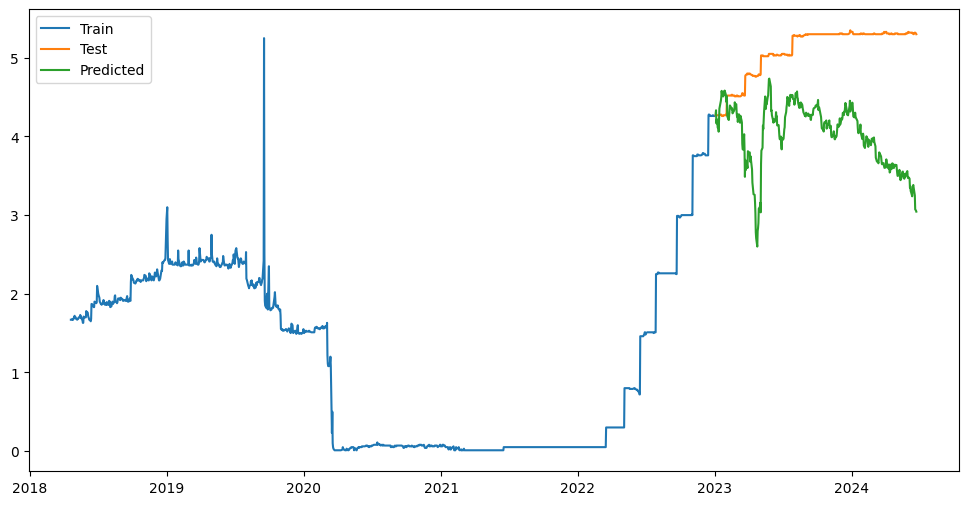

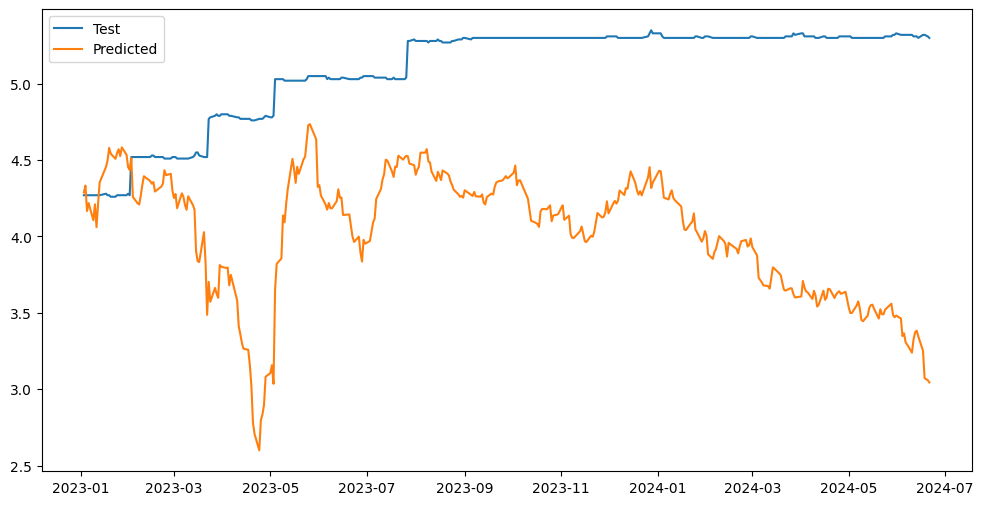

Mean Squared Error: 1.4463
Mean Absolute Error: 1.0851
R2 Score: -12.8677
Root Mean Squared Error: 1.2026
Adjusted R-squared: -19.8015


In [420]:
# Predict using the test set
y_pred_v4 = model_v4_fit.predict(start=len(y_train_v4), end=len(y_train_v4) + len(y_test_v4) - 1, exog=X_test_v4_scaled)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_train_v4.index, y_train_v4, label='Train')
plt.plot(y_test_v4.index, y_test_v4, label='Test')
plt.plot(y_test_v4.index, y_pred_v4, label='Predicted')
plt.legend()
plt.show()

print("\n\n")

plt.figure(figsize=(12, 6))
plt.plot(y_test_v4.index, y_test_v4, label='Test')
plt.plot(y_test_v4.index, y_pred_v4, label='Predicted')
plt.legend()
plt.show()

# Calculate mean squared error
mse = mean_squared_error(y_test_v4, y_pred_v4)
mae = mean_absolute_error(y_test_v4, y_pred_v4)
rsquare = r2_score(y_test_v4, y_pred_v4)
rmse = np.sqrt(mse)
n = len(y_test_v4) # number of rows/observations
k = len(X_test_v4_scaled[0]) # number of independent variables/features
arsquare = adjusted_r_squared(rsquare, n, k)

# Print the evaluation metrics
print(f'Mean Squared Error: {round(mse,4)}')
print(f'Mean Absolute Error: {round(mae,4)}')
print(f'R2 Score: {round(rsquare,4)}')
print(f'Root Mean Squared Error: {round(rmse,4)}')
print(f'Adjusted R-squared: {round(arsquare,4)}')

# Model 5: SARIMAX Model with VIF Feature Selection

## Re-introducing V2 Feature Set as V5

In [421]:
df_model_v5 = df_merged8.copy()
df_model_v5 = df_model_v5.drop(columns=[ 'Rate Type','1st Percentile (%)', '25th Percentile (%)', '75th Percentile (%)', '99th Percentile (%)'])

# Set the 'Date' column as the index
df_model_v5.set_index('Date', inplace=True)
df_model_v5 = df_model_v5.sort_index(ascending=True)
df_model_v5

# Replace 'ND' with NaN and fill with a method or drop rows
df_model_v5.replace('ND', np.nan, inplace=True)

print("NaN values in original features dataframe before dropping:")
print(df_model_v5.isna().sum())

# Drop rows with NaN values in the dataframe
df_model_v5.dropna(inplace=True)

cols = ['SPOT EXCHANGE RATE - EURO AREA ', 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)', 'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. ', 'JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ']
df_model_v5[cols] = df_model_v5[cols].astype(float)

# Re-check for any remaining NaN values
print("\n\nNaN values in original features dataframe after dropping:")
print(df_model_v5.isna().sum())

NaN values in original features dataframe before dropping:
Rate (%)                                                          0
Volume ($Billions)                                                0
4 WEEKS COUPON EQUIVALENT                                         0
13 WEEKS COUPON EQUIVALENT                                        0
26 WEEKS COUPON EQUIVALENT                                        0
52 WEEKS COUPON EQUIVALENT                                        0
LT COMPOSITE (>10 Yrs)                                            0
TREASURY 20-Yr CMT                                                0
Yield Spread (4W - 52W)                                           0
Yield Spread (13W - 52W)                                          0
Yield Spread (26W - 52W)                                          0
Yield Spread (10Y - 4W)                                           0
Yield Spread (20Y - 4W)                                           0
Yield Spread (10Y - 52W)                                 

## Creating Lag & Difference Features

In [422]:
# Define a function to create lag features
def create_lag_features(df, lags, cols):
    for col in cols:
        for lag in lags:
            df[f'{col} - Lag{lag}'] = df[col].shift(lag)
    return df

# Define a function to create differenced features
def create_differenced_features(df, cols_for_first_diff, cols_for_second_diff):
    for col in cols_for_first_diff:
        df[f'{col} - First Differenced'] = df[col].diff()
    for col in cols_for_second_diff:
        df[f'{col} - Second Differenced'] = df[col].diff().diff()
    return df

# Apply differencing and lag feature creation to the DataFrame
def prepare_features(df, cols_for_first_diff, cols_for_second_diff):
    # Columns for which lag features will be created
    cols_for_lags = list(set(df.columns) - set(cols_for_first_diff + cols_for_second_diff))
    cols_for_lags += cols_for_first_diff + cols_for_second_diff  # Ensure all relevant columns are included

    # Create differenced features
    df = create_differenced_features(df, cols_for_first_diff, cols_for_second_diff)

    # Create lag features
    lags = [1, 2, 3, 7, 14]  # Adjust the list of lags based on your needs
    df = create_lag_features(df, lags, cols_for_lags)

    # Drop rows with NaN values created by differencing and lagging
    df.dropna(inplace=True)

    return df

# Specify the columns for first and second differencing
cols_for_first_diff = ['Volume ($Billions)','LT COMPOSITE (>10 Yrs)','TREASURY 20-Yr CMT',
                       'Yield Spread (4W - 52W)','Yield Spread (13W - 52W)','Yield Spread (26W - 52W)',
                       'Yield Spread (10Y - 4W)','Yield Spread (20Y - 4W)','Yield Spread (10Y - 52W)',
                       'Yield Spread (20Y - 52W)','SPX','NASDAQ','DJIA','SPOT EXCHANGE RATE - EURO AREA ',
                       'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)','CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. ',
                       'JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ', 'Unemployment']  # Replace with actual column names that need first differencing

cols_for_second_diff = ['4 WEEKS COUPON EQUIVALENT', '13 WEEKS COUPON EQUIVALENT',
                        '26 WEEKS COUPON EQUIVALENT', '52 WEEKS COUPON EQUIVALENT',
                        'CPI', 'Rate (%)', 'PPI']  # Replace with actual column names that need second differencing

# Prepare the features
df_prepared = prepare_features(df_model_v5.copy(), cols_for_first_diff, cols_for_second_diff)

print("Feature preparation (differencing and lag features) completed.\n\n")
df_prepared.head()

Feature preparation (differencing and lag features) completed.




<ipython-input-422-d8a630295671>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col} - Lag{lag}'] = df[col].shift(lag)
<ipython-input-422-d8a630295671>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col} - Lag{lag}'] = df[col].shift(lag)
<ipython-input-422-d8a630295671>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fram

,Rate (%),Volume ($Billions),4 WEEKS COUPON EQUIVALENT,13 WEEKS COUPON EQUIVALENT,26 WEEKS COUPON EQUIVALENT,52 WEEKS COUPON EQUIVALENT,LT COMPOSITE (>10 Yrs),TREASURY 20-Yr CMT,Yield Spread (4W - 52W),Yield Spread (13W - 52W),...,Rate (%) - Lag1,Rate (%) - Lag2,Rate (%) - Lag3,Rate (%) - Lag7,Rate (%) - Lag14,PPI - Lag1,PPI - Lag2,PPI - Lag3,PPI - Lag7,PPI - Lag14
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-20,1.67,340,1.64,1.81,2.01,2.20,3.09,3.04,0.56,0.39,...,1.67,1.69,1.70,1.70,1.77,115.5,115.5,115.5,115.5,115.5
2018-04-23,1.67,348,1.66,1.87,2.04,2.22,3.10,3.05,0.56,0.35,...,1.67,1.67,1.69,1.68,1.81,115.5,115.5,115.5,115.5,115.5
2018-04-24,1.68,339,1.70,1.87,2.05,2.25,3.12,3.08,0.55,0.38,...,1.67,1.67,1.67,1.68,1.70,115.5,115.5,115.5,115.5,115.5
2018-04-25,1.67,345,1.64,1.85,2.03,2.26,3.16,3.12,0.62,0.41,...,1.68,1.67,1.67,1.70,1.70,115.5,115.5,115.5,115.5,115.5
2018-04-26,1.67,333,1.61,1.82,2.02,2.25,3.13,3.08,0.64,0.43,...,1.67,1.68,1.67,1.70,1.70,115.5,115.5,115.5,115.5,115.5


## Use Correlation Matrix to create High Correlation Pairs

In [423]:
correlation_matrix = df_prepared.corr().abs()  # Use absolute values to consider both positive and negative correlations

# Create a mask to ignore the diagonal elements (self-correlations)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Apply the mask to the correlation matrix
correlation_matrix = correlation_matrix.mask(mask)

# Set a threshold for high correlations (e.g., 0.8)
high_correlation_threshold = 0.8

# Find pairs of features with correlation above the threshold
high_correlation_pairs = np.where(correlation_matrix > high_correlation_threshold)
high_correlation_pairs = [(correlation_matrix.index[x], correlation_matrix.columns[y])
                          for x, y in zip(*high_correlation_pairs) if x != y]

print("Highly correlated pairs of features:")
print(high_correlation_pairs)

Highly correlated pairs of features:
[('Volume ($Billions)', 'Rate (%)'), ('4 WEEKS COUPON EQUIVALENT', 'Rate (%)'), ('4 WEEKS COUPON EQUIVALENT', 'Volume ($Billions)'), ('13 WEEKS COUPON EQUIVALENT', 'Rate (%)'), ('13 WEEKS COUPON EQUIVALENT', '4 WEEKS COUPON EQUIVALENT'), ('26 WEEKS COUPON EQUIVALENT', 'Rate (%)'), ('26 WEEKS COUPON EQUIVALENT', '4 WEEKS COUPON EQUIVALENT'), ('26 WEEKS COUPON EQUIVALENT', '13 WEEKS COUPON EQUIVALENT'), ('52 WEEKS COUPON EQUIVALENT', 'Rate (%)'), ('52 WEEKS COUPON EQUIVALENT', '4 WEEKS COUPON EQUIVALENT'), ('52 WEEKS COUPON EQUIVALENT', '13 WEEKS COUPON EQUIVALENT'), ('52 WEEKS COUPON EQUIVALENT', '26 WEEKS COUPON EQUIVALENT'), ('LT COMPOSITE (>10 Yrs)', 'Rate (%)'), ('LT COMPOSITE (>10 Yrs)', '4 WEEKS COUPON EQUIVALENT'), ('LT COMPOSITE (>10 Yrs)', '13 WEEKS COUPON EQUIVALENT'), ('LT COMPOSITE (>10 Yrs)', '26 WEEKS COUPON EQUIVALENT'), ('LT COMPOSITE (>10 Yrs)', '52 WEEKS COUPON EQUIVALENT'), ('TREASURY 20-Yr CMT', 'Rate (%)'), ('TREASURY 20-Yr CMT',

## Use Variance Inflation Factor (VIF) to Eliminate Features

In [424]:
vif_df = df_prepared.copy()
# Set to keep track of features to drop
features_to_drop = set()

for pair in high_correlation_pairs:
    feature1, feature2 = pair

    # Drop the second feature of the pair
    features_to_drop.add(feature2)

# Drop the features from the DataFrame
df_reduced = vif_df.drop(columns=features_to_drop)

print("Features dropped due to high correlation:")
print(features_to_drop)

Features dropped due to high correlation:
{'4 WEEKS COUPON EQUIVALENT - Lag3', 'Yield Spread (26W - 52W) - Lag7', '26 WEEKS COUPON EQUIVALENT - Lag3', 'Rate (%)', 'SPX - Lag7', 'DJIA - Lag2', 'Yield Spread (20Y - 4W) - Lag7', 'PPI - Lag3', 'LT COMPOSITE (>10 Yrs) - Lag1', 'Yield Spread (20Y - 4W)', 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK) - Lag3', 'Unemployment', '52 WEEKS COUPON EQUIVALENT', 'Unemployment - Lag3', 'Yield Spread (4W - 52W)', 'Yield Spread (13W - 52W) - Lag1', 'Volume ($Billions) - Lag14', 'SPX - Lag14', 'Yield Spread (10Y - 52W) - Lag14', 'CPI - Lag2', 'Volume ($Billions)', 'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  - Lag7', 'PPI - Lag1', 'Yield Spread (10Y - 4W) - Lag7', 'SPOT EXCHANGE RATE - EURO AREA  - Lag1', '52 WEEKS COUPON EQUIVALENT - Lag1', 'Yield Spread (13W - 52W) - Lag14', 'Yield Spread (10Y - 52W) - Lag2', '13 WEEKS COUPON EQUIVALENT - Lag14', '26 WEEKS COUPON EQUIVALENT - Lag1', 'CPI - Lag7', 'CHINA -- SPOT EXCHANGE RATE, YUAN/US$

In [425]:
X = df_reduced.values
vif_df = pd.DataFrame()
vif_df["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif_df["Variable"] = df_reduced.columns

print("VIF values after handling multicollinearity:")
vif_df

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF values after handling multicollinearity:


/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,VIF,Variable
0,1.072388,Volume ($Billions) - First Differenced
1,7.863210,TREASURY 20-Yr CMT - First Differenced
2,inf,Yield Spread (4W - 52W) - First Differenced
3,8.006091,Yield Spread (13W - 52W) - First Differenced
4,7.529261,Yield Spread (26W - 52W) - First Differenced
5,inf,Yield Spread (20Y - 4W) - First Differenced
6,inf,Yield Spread (20Y - 52W) - First Differenced
7,2.762981,NASDAQ - First Differenced
8,2.925376,DJIA - First Differenced
9,2.046784,SPOT EXCHANGE RATE - EURO AREA - First Differ...


## High VIF columns to drop

In [426]:
columns_to_drop = [
 'TREASURY 20-Yr CMT - First Differenced',
 'Yield Spread (4W - 52W) - First Differenced',
 'Yield Spread (13W - 52W) - First Differenced',
 'Yield Spread (26W - 52W) - First Differenced',
 'Yield Spread (20Y - 4W) - First Differenced',
 'Yield Spread (20Y - 52W) - First Differenced',
 '26 WEEKS COUPON EQUIVALENT - Second Differenced',
 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK) - Lag14',
 'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  - Lag14',
 'Unemployment - Lag14',
 'PPI - Lag14',
 'Rate (%) - Lag14']

df_prepared_nona = df_reduced.drop(columns=columns_to_drop)
df_prepared_nona['Rate (%)'] = df_model_v5['Rate (%)']

## Training

In [427]:
# Split into train and test

train_v5 = df_prepared_nona[:'2022-12-31']
test_v5 = df_prepared_nona['2023-01-01':]

# Split into X & y

# y_train_v5 = train_v5['Rate (%) - Second Differenced']
# X_train_v5 = train_v5.drop(columns=['Rate (%) - Second Differenced'])
# y_test_v5 = test_v5['Rate (%) - Second Differenced']
# X_test_v5 = test_v5.drop(columns=['Rate (%) - Second Differenced'])

y_train_v5 = train_v5['Rate (%)']
X_train_v5 = train_v5.drop(columns=['Rate (%)'])
y_test_v5 = test_v5['Rate (%)']
X_test_v5 = test_v5.drop(columns=['Rate (%)'])


# Scaling values

scaler = MinMaxScaler()
X_train_v5_scaled = scaler.fit_transform(X_train_v5)
X_test_v5_scaled = scaler.transform(X_test_v5)

# model definition

model_v5 = SARIMAX(y_train_v5, exog= X_train_v5_scaled, order= (2,1,1), seasonal_order= (1,1,2,4)) # order was (1,1,1) seasonal_order was (0,0,0,0)
# (p, d, q) = (1,1,2) so dependent is differenced 1 (d) time, dependent lag 1 (p), error lag 2 (q)
# (P, D, Q, s) = (2,1,1,6) seasonal differencing 1 (D) time on a period of 6 (s), seasonal lag 2 (P), moving average 1 (Q)

model_v5_fit = model_v5.fit(disp=False)
print(model_v5_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                       SARIMAX Results                                        
Dep. Variable:                               Rate (%)   No. Observations:                 1167
Model:             SARIMAX(2, 1, 1)x(1, 1, [1, 2], 4)   Log Likelihood                1005.077
Date:                                Sun, 18 Aug 2024   AIC                          -1968.154
Time:                                        04:26:28   BIC                          -1861.938
Sample:                                             0   HQIC                         -1928.080
                                               - 1167                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0109      0.018     -0.601      0.548      -0.047       0.025
x2 

## Testing

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


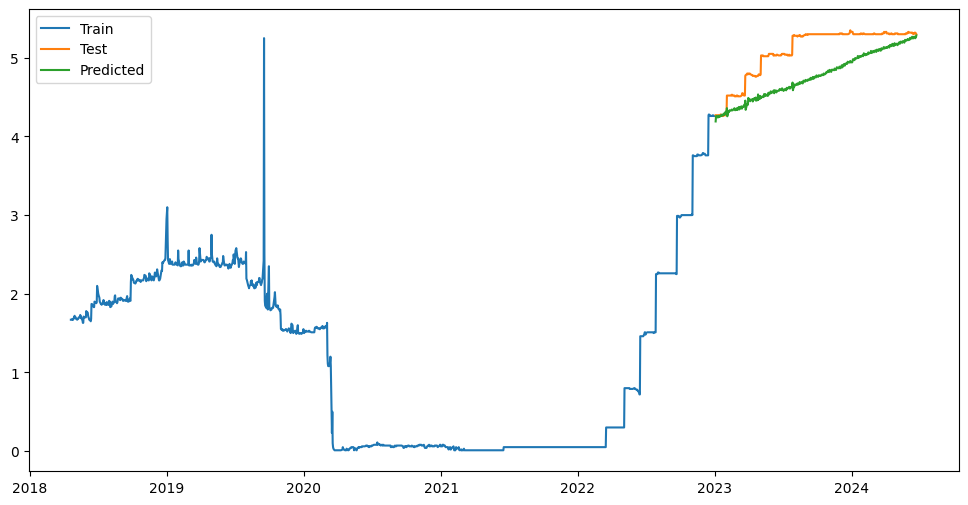

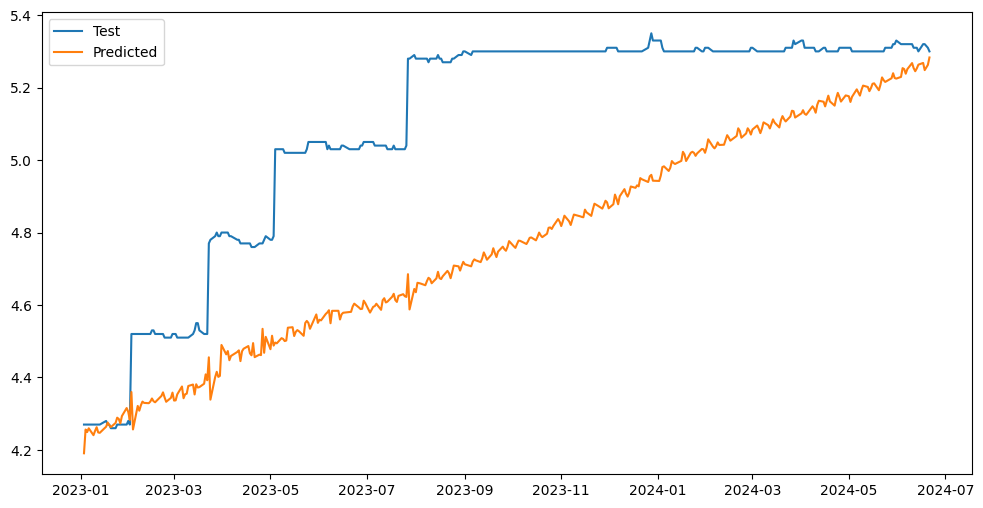

Mean Squared Error: 0.1347
Mean Absolute Error: 0.3214
R2 Score: -0.2919
Root Mean Squared Error: 0.3671
Adj R2 Score: -0.3433


In [428]:
# Predict using the test set
y_pred_v5 = model_v5_fit.predict(start=len(y_train_v5), end=len(y_train_v5) + len(y_test_v5) - 1, exog=X_test_v5_scaled)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_train_v5.index, y_train_v5, label='Train')
plt.plot(y_test_v5.index, y_test_v5, label='Test')
plt.plot(y_test_v5.index, y_pred_v5, label='Predicted')
plt.legend()
plt.show()

print("\n\n")

plt.figure(figsize=(12, 6))
plt.plot(y_test_v5.index, y_test_v5, label='Test')
plt.plot(y_test_v5.index, y_pred_v5, label='Predicted')
plt.legend()
plt.show()

# Calculate mean squared error
mse = mean_squared_error(y_test_v5, y_pred_v5)
mae = mean_absolute_error(y_test_v5, y_pred_v5)
rsquare = r2_score(y_test_v5, y_pred_v5)
n = len(y_test_v5)
k = len(X_test_v5_scaled[0])
rmse = np.sqrt(mse)
arsquare = 1 - (1 - rsquare) * ((n - 1) / (n - k - 1))

# Print the evaluation metrics
print(f'Mean Squared Error: {round(mse,4)}')
print(f'Mean Absolute Error: {round(mae,4)}')
print(f'R2 Score: {round(rsquare,4)}')
print(f'Root Mean Squared Error: {round(rmse,4)}')
print(f'Adj R2 Score: {round(arsquare,4)}')

# Model 6: SARIMAX Model with Additional Features and GARCH

## Add Fed Security Holdings

In [429]:
wsho_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/WSHOSHO.csv'
df = pd.read_csv(wsho_path)
df.rename(columns={'DATE': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])

df_merged9 = pd.merge(df_merged8, df, on='Date', how='left')

df_merged9['WSHOSHO'] = df_merged9['WSHOSHO'].fillna(method = 'bfill')
df_merged9['WSHOSHO'] = df_merged9['WSHOSHO'].fillna(method= 'ffill')

<ipython-input-429-8f6a5a3ff7fb>:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_merged9['WSHOSHO'] = df_merged9['WSHOSHO'].fillna(method = 'bfill')
<ipython-input-429-8f6a5a3ff7fb>:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_merged9['WSHOSHO'] = df_merged9['WSHOSHO'].fillna(method= 'ffill')


## Overnight Reverse Repo Facility (RRP)

In [430]:
rrpo_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/RRPONTSYD.csv'
df = pd.read_csv(rrpo_path)
df.rename(columns={'DATE': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])

median_value = 162.8
df = df.replace('.', median_value)
df['RRPONTSYD'] = df['RRPONTSYD'].astype(float)

df_merged10 = pd.merge(df_merged9, df, on='Date', how='inner')

## Add Probability of rate hike/cut

In [431]:
wirp_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/Bloomberg data - WIRP AUG8 2024.csv'
df = pd.read_csv(wirp_path)
df.rename(columns={'Data': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])

df_merged11 = pd.merge(df_merged10, df, on='Date', how='inner')

## Final Feature Set

In [432]:
df_final = df_merged11.copy()
df_final = df_final.drop(columns=[ 'Rate Type','1st Percentile (%)', '25th Percentile (%)', '75th Percentile (%)', '99th Percentile (%)'])

df_final['Year'] = df_final['Date'].dt.year
df_final['Month'] = df_final['Date'].dt.month
df_final['Day'] = df_final['Date'].dt.day

# Set the 'Date' column as the index
df_final.set_index('Date', inplace=True)
df_final2 = df_final.sort_index(ascending=True)
df_final2

# Replace 'ND' with NaN and fill with a method or drop rows
df_final2.replace('ND', np.nan, inplace=True)

# Drop rows with NaN values in the dataframe
df_final2.dropna(inplace=True)

# Convert columns to float
cols = ['SPOT EXCHANGE RATE - EURO AREA ', 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)', 'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. ', 'JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ']
df_final2[cols] = df_final2[cols].astype(float)

## Stationarity Checks

In [433]:
df_stationary = df_final2.copy()

# Function to check stationarity and apply differencing
def ensure_stationarity(series, name):
    try:
        print(f"\nChecking stationarity for {name}:\n")
        adf_test(series, title=name)
        print("\n")
        kpss_test(series, title=name)

        # Check stationarity after the first differencing if necessary
        if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
            print(f"\n{name} is not stationary. Applying first differencing.\n")
            series = series.diff().dropna()

            # Ensure no infinite or NaN values
            if np.isinf(series).any() or series.isna().any():
                series.replace([np.inf, -np.inf], np.nan, inplace=True)
                series.dropna(inplace=True)

            print(f"\nRe-checking stationarity for {name} after first differencing:\n")
            adf_test(series, title=f"{name} - First Differenced")
            print("\n")
            kpss_test(series, title=f"{name} - First Differenced")

            # Check stationarity after the second differencing if necessary
            if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
                print(f"\n{name} is still not stationary. Applying second differencing.\n")
                series = series.diff().dropna()

                # Ensure no infinite or NaN values
                if np.isinf(series).any() or series.isna().any():
                    series.replace([np.inf, -np.inf], np.nan, inplace=True)
                    series.dropna(inplace=True)

                print(f"\nRe-checking stationarity for {name} after second differencing:\n")
                adf_test(series, title=f"{name} - Second Differenced")
                print("\n")
                kpss_test(series, title=f"{name} - Second Differenced")
            else:
                print(f"\n{name} is stationary after first differencing.\n")
        else:
            print(f"{name} is already stationary.\n")
    except Exception as e:
        print(f"An error occurred while processing {name}: {e}")

    return series

# Apply the function to each explanatory variable
for col in df_stationary.columns:
    if col not in ['Rate (%)', 'Rate (%) - First Differenced', 'Rate (%) - Second Differenced']:
        df_stationary[col] = ensure_stationarity(df_final2[col], col)

# Now, let's ensure the 'Rate (%)' column is also stationary, applying the same procedure
df_stationary['Rate (%)'] = ensure_stationarity(df_final2['Rate (%)'], 'Rate (%)')

print("Stationarity check and differencing completed.")


Checking stationarity for Volume ($Billions):

===Augmented Dickey-Fuller Test: Volume ($Billions)===
ADF Test Statistic                0.769329
p-value                           0.991125
#Lags Used                       13.000000
Number of Observations Used    1532.000000
Critical Value (1%)              -3.434626
Critical Value (5%)              -2.863428
Critical Value (10%)             -2.567775
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Volume ($Billions)===
KPSS Test Statistic       2.145503
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

Volume ($Billions) is not stationary. Applying first differencing.


Re-checking stationarity for Volume ($Billi

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: Volume ($Billions) - First Differenced===
ADF Test Statistic            -1.262452e+01
p-value                        1.552087e-23
#Lags Used                     1.200000e+01
Number of Observations Used    1.532000e+03
Critical Value (1%)           -3.434626e+00
Critical Value (5%)           -2.863428e+00
Critical Value (10%)          -2.567775e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Volume ($Billions) - First Differenced===
KPSS Test Statistic       0.381160
p-value                   0.085276
#Lags Used               21.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null hypothesis, time series is stationary

Volume ($Billions) is stationary after first differencing.


Checking stationarity for 4 WEEKS COUPON EQUIVALENT:

===Augmented Dic

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: 4 WEEKS COUPON EQUIVALENT - First Differenced===
ADF Test Statistic            -7.197427e+00
p-value                        2.414168e-10
#Lags Used                     2.400000e+01
Number of Observations Used    1.520000e+03
Critical Value (1%)           -3.434659e+00
Critical Value (5%)           -2.863443e+00
Critical Value (10%)          -2.567783e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: 4 WEEKS COUPON EQUIVALENT - First Differenced===
KPSS Test Statistic       0.596015
p-value                   0.022999
#Lags Used               21.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

4 WEEKS COUPON EQUIVALENT is still not stationary. Applying second differencing.


Re-chec

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



13 WEEKS COUPON EQUIVALENT is not stationary. Applying first differencing.


Re-checking stationarity for 13 WEEKS COUPON EQUIVALENT after first differencing:

===Augmented Dickey-Fuller Test: 13 WEEKS COUPON EQUIVALENT - First Differenced===
ADF Test Statistic            -5.989547e+00
p-value                        1.758987e-07
#Lags Used                     2.100000e+01
Number of Observations Used    1.523000e+03
Critical Value (1%)           -3.434651e+00
Critical Value (5%)           -2.863440e+00
Critical Value (10%)          -2.567781e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: 13 WEEKS COUPON EQUIVALENT - First Differenced===
KPSS Test Statistic       0.95965
p-value                   0.01000
#Lags Used               22.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
Strong evidence against the nul

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-433-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:


===Augmented Dickey-Fuller Test: 13 WEEKS COUPON EQUIVALENT - Second Differenced===
ADF Test Statistic            -1.319863e+01
p-value                        1.106107e-24
#Lags Used                     2.200000e+01
Number of Observations Used    1.521000e+03
Critical Value (1%)           -3.434657e+00
Critical Value (5%)           -2.863442e+00
Critical Value (10%)          -2.567783e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: 13 WEEKS COUPON EQUIVALENT - Second Differenced===
KPSS Test Statistic       0.01381
p-value                   0.10000
#Lags Used               28.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
Weak evidence against the null hypothesis, time series is stationary

Checking stationarity for 26 WEEKS COUPON EQUIVALENT:

===Augmented Dickey-Fuller Test: 26 WEEKS COUPON EQUIVALENT===
AD

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



26 WEEKS COUPON EQUIVALENT is not stationary. Applying first differencing.


Re-checking stationarity for 26 WEEKS COUPON EQUIVALENT after first differencing:

===Augmented Dickey-Fuller Test: 26 WEEKS COUPON EQUIVALENT - First Differenced===
ADF Test Statistic            -5.898274e+00
p-value                        2.817452e-07
#Lags Used                     1.900000e+01
Number of Observations Used    1.525000e+03
Critical Value (1%)           -3.434645e+00
Critical Value (5%)           -2.863437e+00
Critical Value (10%)          -2.567780e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: 26 WEEKS COUPON EQUIVALENT - First Differenced===
KPSS Test Statistic       0.948526
p-value                   0.010000
#Lags Used               20.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against 

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-433-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:


===Augmented Dickey-Fuller Test: 26 WEEKS COUPON EQUIVALENT - Second Differenced===
ADF Test Statistic            -1.521273e+01
p-value                        5.625099e-28
#Lags Used                     1.800000e+01
Number of Observations Used    1.525000e+03
Critical Value (1%)           -3.434645e+00
Critical Value (5%)           -2.863437e+00
Critical Value (10%)          -2.567780e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: 26 WEEKS COUPON EQUIVALENT - Second Differenced===
KPSS Test Statistic       0.006263
p-value                   0.100000
#Lags Used               17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null hypothesis, time series is stationary

Checking stationarity for 52 WEEKS COUPON EQUIVALENT:

===Augmented Dickey-Fuller Test: 52 WEEKS COUPON EQUIVALEN

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



52 WEEKS COUPON EQUIVALENT is not stationary. Applying first differencing.


Re-checking stationarity for 52 WEEKS COUPON EQUIVALENT after first differencing:

===Augmented Dickey-Fuller Test: 52 WEEKS COUPON EQUIVALENT - First Differenced===
ADF Test Statistic            -6.320991e+00
p-value                        3.066545e-08
#Lags Used                     2.100000e+01
Number of Observations Used    1.523000e+03
Critical Value (1%)           -3.434651e+00
Critical Value (5%)           -2.863440e+00
Critical Value (10%)          -2.567781e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: 52 WEEKS COUPON EQUIVALENT - First Differenced===
KPSS Test Statistic      1.035431
p-value                  0.010000
#Lags Used               8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Strong evidence against the nul

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-433-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:


===Augmented Dickey-Fuller Test: 52 WEEKS COUPON EQUIVALENT - Second Differenced===
ADF Test Statistic            -1.477315e+01
p-value                        2.305807e-27
#Lags Used                     2.000000e+01
Number of Observations Used    1.523000e+03
Critical Value (1%)           -3.434651e+00
Critical Value (5%)           -2.863440e+00
Critical Value (10%)          -2.567781e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: 52 WEEKS COUPON EQUIVALENT - Second Differenced===
KPSS Test Statistic       0.015698
p-value                   0.100000
#Lags Used               49.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null hypothesis, time series is stationary

Checking stationarity for LT COMPOSITE (>10 Yrs):

===Augmented Dickey-Fuller Test: LT COMPOSITE (>10 Yrs)===
ADF

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



LT COMPOSITE (>10 Yrs) is not stationary. Applying first differencing.


Re-checking stationarity for LT COMPOSITE (>10 Yrs) after first differencing:

===Augmented Dickey-Fuller Test: LT COMPOSITE (>10 Yrs) - First Differenced===
ADF Test Statistic              -29.730934
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    1543.000000
Critical Value (1%)              -3.434595
Critical Value (5%)              -2.863415
Critical Value (10%)             -2.567768
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: LT COMPOSITE (>10 Yrs) - First Differenced===
KPSS Test Statistic      0.305433
p-value                  0.100000
#Lags Used               0.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Weak evidence against the null hypothesis, time series

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-433-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



TREASURY 20-Yr CMT is not stationary. Applying first differencing.


Re-checking stationarity for TREASURY 20-Yr CMT after first differencing:

===Augmented Dickey-Fuller Test: TREASURY 20-Yr CMT - First Differenced===
ADF Test Statistic              -29.814525
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    1543.000000
Critical Value (1%)              -3.434595
Critical Value (5%)              -2.863415
Critical Value (10%)             -2.567768
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: TREASURY 20-Yr CMT - First Differenced===
KPSS Test Statistic      0.320226
p-value                  0.100000
#Lags Used               1.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Weak evidence against the null hypothesis, time series is stationary



<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-433-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:


===Augmented Dickey-Fuller Test: Yield Spread (4W - 52W) - First Differenced===
ADF Test Statistic            -1.037523e+01
p-value                        2.210509e-18
#Lags Used                     2.200000e+01
Number of Observations Used    1.522000e+03
Critical Value (1%)           -3.434654e+00
Critical Value (5%)           -2.863441e+00
Critical Value (10%)          -2.567782e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Yield Spread (4W - 52W) - First Differenced===
KPSS Test Statistic       0.052466
p-value                   0.100000
#Lags Used               19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null hypothesis, time series is stationary

Yield Spread (4W - 52W) is stationary after first differencing.


Checking stationarity for Yield Spread (13W - 52W):

==

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-433-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:


===Augmented Dickey-Fuller Test: Yield Spread (13W - 52W) - First Differenced===
ADF Test Statistic            -8.260063e+00
p-value                        5.111853e-13
#Lags Used                     2.200000e+01
Number of Observations Used    1.522000e+03
Critical Value (1%)           -3.434654e+00
Critical Value (5%)           -2.863441e+00
Critical Value (10%)          -2.567782e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Yield Spread (13W - 52W) - First Differenced===
KPSS Test Statistic      0.075552
p-value                  0.100000
#Lags Used               6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Weak evidence against the null hypothesis, time series is stationary

Yield Spread (13W - 52W) is stationary after first differencing.


Checking stationarity for Yield Spread (26W - 52W):

===Aug

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-433-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



Yield Spread (26W - 52W) is not stationary. Applying first differencing.


Re-checking stationarity for Yield Spread (26W - 52W) after first differencing:

===Augmented Dickey-Fuller Test: Yield Spread (26W - 52W) - First Differenced===
ADF Test Statistic            -8.356732e+00
p-value                        2.895650e-13
#Lags Used                     2.200000e+01
Number of Observations Used    1.522000e+03
Critical Value (1%)           -3.434654e+00
Critical Value (5%)           -2.863441e+00
Critical Value (10%)          -2.567782e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Yield Spread (26W - 52W) - First Differenced===
KPSS Test Statistic       0.065076
p-value                   0.100000
#Lags Used               20.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null h

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-433-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



Yield Spread (10Y - 4W) is not stationary. Applying first differencing.


Re-checking stationarity for Yield Spread (10Y - 4W) after first differencing:

===Augmented Dickey-Fuller Test: Yield Spread (10Y - 4W) - First Differenced===
ADF Test Statistic            -9.001523e+00
p-value                        6.478101e-15
#Lags Used                     2.100000e+01
Number of Observations Used    1.523000e+03
Critical Value (1%)           -3.434651e+00
Critical Value (5%)           -2.863440e+00
Critical Value (10%)          -2.567781e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Yield Spread (10Y - 4W) - First Differenced===
KPSS Test Statistic       0.133747
p-value                   0.100000
#Lags Used               17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null hypot

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-433-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



Yield Spread (20Y - 4W) is not stationary. Applying first differencing.


Re-checking stationarity for Yield Spread (20Y - 4W) after first differencing:

===Augmented Dickey-Fuller Test: Yield Spread (20Y - 4W) - First Differenced===
ADF Test Statistic            -9.006860e+00
p-value                        6.277574e-15
#Lags Used                     2.100000e+01
Number of Observations Used    1.523000e+03
Critical Value (1%)           -3.434651e+00
Critical Value (5%)           -2.863440e+00
Critical Value (10%)          -2.567781e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Yield Spread (20Y - 4W) - First Differenced===
KPSS Test Statistic       0.139397
p-value                   0.100000
#Lags Used               17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null hypot

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-433-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



Yield Spread (10Y - 52W) is not stationary. Applying first differencing.


Re-checking stationarity for Yield Spread (10Y - 52W) after first differencing:

===Augmented Dickey-Fuller Test: Yield Spread (10Y - 52W) - First Differenced===
ADF Test Statistic              -21.686716
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    1541.000000
Critical Value (1%)              -3.434601
Critical Value (5%)              -2.863417
Critical Value (10%)             -2.567769
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Yield Spread (10Y - 52W) - First Differenced===
KPSS Test Statistic       0.226301
p-value                   0.100000
#Lags Used               13.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null hypothes

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-433-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



Yield Spread (20Y - 52W) is not stationary. Applying first differencing.


Re-checking stationarity for Yield Spread (20Y - 52W) after first differencing:

===Augmented Dickey-Fuller Test: Yield Spread (20Y - 52W) - First Differenced===
ADF Test Statistic              -21.750841
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    1541.000000
Critical Value (1%)              -3.434601
Critical Value (5%)              -2.863417
Critical Value (10%)             -2.567769
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Yield Spread (20Y - 52W) - First Differenced===
KPSS Test Statistic       0.240508
p-value                   0.100000
#Lags Used               14.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null hypothes

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-433-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:


===Augmented Dickey-Fuller Test: CPI===
ADF Test Statistic                0.621968
p-value                           0.988145
#Lags Used                       23.000000
Number of Observations Used    1522.000000
Critical Value (1%)              -3.434654
Critical Value (5%)              -2.863441
Critical Value (10%)             -2.567782
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: CPI===
KPSS Test Statistic       5.858555
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

CPI is not stationary. Applying first differencing.


Re-checking stationarity for CPI after first differencing:

===Augmented Dickey-Fuller Test: CPI - First Differenced===
ADF Test Statist

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: CPI - Second Differenced===
ADF Test Statistic              -20.426312
p-value                           0.000000
#Lags Used                       22.000000
Number of Observations Used    1521.000000
Critical Value (1%)              -3.434657
Critical Value (5%)              -2.863442
Critical Value (10%)             -2.567783
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


An error occurred while processing CPI: cannot convert float infinity to integer

Checking stationarity for SPX:

===Augmented Dickey-Fuller Test: SPX===
ADF Test Statistic               -0.377199
p-value                           0.913837
#Lags Used                        9.000000
Number of Observations Used    1536.000000
Critical Value (1%)              -3.434614
Critical Value (5%)              -2.863424
Critical Value (10%)             -2.567773
Weak evidence against the null hypothesis, time series has a unit ro

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2171: RuntimeWarning: divide by zero encountered in scalar divide
  s_hat = s1 / s0
<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-433-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-414-1a6fba92cac3>:2: Interpola


SPX is stationary after first differencing.


Checking stationarity for NASDAQ:

===Augmented Dickey-Fuller Test: NASDAQ===
ADF Test Statistic               -0.460287
p-value                           0.899536
#Lags Used                        9.000000
Number of Observations Used    1536.000000
Critical Value (1%)              -3.434614
Critical Value (5%)              -2.863424
Critical Value (10%)             -2.567773
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: NASDAQ===
KPSS Test Statistic       4.369509
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

NASDAQ is not stationary. Applying first differencing.


Re-checking stationarity for NASDAQ after fir

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-433-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



DJIA is not stationary. Applying first differencing.


Re-checking stationarity for DJIA after first differencing:

===Augmented Dickey-Fuller Test: DJIA - First Differenced===
ADF Test Statistic            -1.226097e+01
p-value                        9.081206e-23
#Lags Used                     8.000000e+00
Number of Observations Used    1.536000e+03
Critical Value (1%)           -3.434614e+00
Critical Value (5%)           -2.863424e+00
Critical Value (10%)          -2.567773e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: DJIA - First Differenced===
KPSS Test Statistic      0.032947
p-value                  0.100000
#Lags Used               4.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Weak evidence against the null hypothesis, time series is stationary

DJIA is stationary after first differencing.


Ch

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-433-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



SPOT EXCHANGE RATE - EURO AREA  is not stationary. Applying first differencing.


Re-checking stationarity for SPOT EXCHANGE RATE - EURO AREA  after first differencing:

===Augmented Dickey-Fuller Test: SPOT EXCHANGE RATE - EURO AREA  - First Differenced===
ADF Test Statistic            -1.738202e+01
p-value                        5.066447e-30
#Lags Used                     5.000000e+00
Number of Observations Used    1.539000e+03
Critical Value (1%)           -3.434606e+00
Critical Value (5%)           -2.863420e+00
Critical Value (10%)          -2.567771e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: SPOT EXCHANGE RATE - EURO AREA  - First Differenced===
KPSS Test Statistic      0.087842
p-value                  0.100000
#Lags Used               3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Weak eviden

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-433-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK) is not stationary. Applying first differencing.


Re-checking stationarity for UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK) after first differencing:

===Augmented Dickey-Fuller Test: UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK) - First Differenced===
ADF Test Statistic            -1.242900e+01
p-value                        3.979259e-23
#Lags Used                     1.000000e+01
Number of Observations Used    1.534000e+03
Critical Value (1%)           -3.434620e+00
Critical Value (5%)           -2.863426e+00
Critical Value (10%)          -2.567774e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK) - First Differenced===
KPSS Test Statistic      0.073366
p-value                  0.100000
#Lags Used               5.000000
Critical Value (10%)   

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-433-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



KPSS Test Statistic       1.202364
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  is not stationary. Applying first differencing.


Re-checking stationarity for CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  after first differencing:

===Augmented Dickey-Fuller Test: CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  - First Differenced===
ADF Test Statistic            -1.823553e+01
p-value                        2.361667e-30
#Lags Used                     3.000000e+00
Number of Observations Used    1.541000e+03
Critical Value (1%)           -3.434601e+00
Critical Value (5%)           -2.863417e+00
Critical Value (10%)          -2.567769e+00
Strong evidence against the null hypothesis, reject the

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-433-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  is stationary after first differencing.


Checking stationarity for JAPAN -- SPOT EXCHANGE RATE, YEN/US$ :

===Augmented Dickey-Fuller Test: JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ===
ADF Test Statistic                0.826013
p-value                           0.992045
#Lags Used                        3.000000
Number of Observations Used    1542.000000
Critical Value (1%)              -3.434598
Critical Value (5%)              -2.863416
Critical Value (10%)             -2.567769
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ===
KPSS Test Statistic       4.754346
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypot

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-433-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



JAPAN -- SPOT EXCHANGE RATE, YEN/US$  is stationary after first differencing.


Checking stationarity for PPI:

===Augmented Dickey-Fuller Test: PPI===
ADF Test Statistic                0.072876
p-value                           0.964160
#Lags Used                       23.000000
Number of Observations Used    1522.000000
Critical Value (1%)              -3.434654
Critical Value (5%)              -2.863441
Critical Value (10%)             -2.567782
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: PPI===
KPSS Test Statistic       5.787073
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

PPI is not stationary. Applying first differencing.


Re-checking stationarit

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-433-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:



Unemployment is not stationary. Applying first differencing.


Re-checking stationarity for Unemployment after first differencing:

===Augmented Dickey-Fuller Test: Unemployment - First Differenced===
ADF Test Statistic              -39.268310
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1544.000000
Critical Value (1%)              -3.434592
Critical Value (5%)              -2.863414
Critical Value (10%)             -2.567768
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Unemployment - First Differenced===
KPSS Test Statistic      0.041382
p-value                  0.100000
#Lags Used               0.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Weak evidence against the null hypothesis, time series is stationary

Unemployment is stationa

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-433-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:


===Augmented Dickey-Fuller Test: WSHOSHO - Second Differenced===
ADF Test Statistic            -1.151101e+01
p-value                        4.259996e-21
#Lags Used                     2.300000e+01
Number of Observations Used    1.520000e+03
Critical Value (1%)           -3.434659e+00
Critical Value (5%)           -2.863443e+00
Critical Value (10%)          -2.567783e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: WSHOSHO - Second Differenced===
KPSS Test Statistic       0.011519
p-value                   0.100000
#Lags Used               34.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null hypothesis, time series is stationary

Checking stationarity for RRPONTSYD:

===Augmented Dickey-Fuller Test: RRPONTSYD===
ADF Test Statistic               -1.016896
p-value                 

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-433-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05


RRPONTSYD is still not stationary. Applying second differencing.


Re-checking stationarity for RRPONTSYD after second differencing:

===Augmented Dickey-Fuller Test: RRPONTSYD - Second Differenced===
ADF Test Statistic            -1.520091e+01
p-value                        5.831453e-28
#Lags Used                     2.400000e+01
Number of Observations Used    1.519000e+03
Critical Value (1%)           -3.434662e+00
Critical Value (5%)           -2.863445e+00
Critical Value (10%)          -2.567784e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: RRPONTSYD - Second Differenced===
KPSS Test Statistic       0.033887
p-value                   0.100000
#Lags Used               76.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null hypothesis, time series is stationary

Checking sta

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-433-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



Year is not stationary. Applying first differencing.


Re-checking stationarity for Year after first differencing:

===Augmented Dickey-Fuller Test: Year - First Differenced===
ADF Test Statistic              -39.421800
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1544.000000
Critical Value (1%)              -3.434592
Critical Value (5%)              -2.863414
Critical Value (10%)             -2.567768
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Year - First Differenced===
KPSS Test Statistic      0.017675
p-value                  0.100000
#Lags Used               3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Weak evidence against the null hypothesis, time series is stationary

Year is stationary after first differencing.


Checking 

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-433-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-433-622013a18d5a>:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value retur

===Augmented Dickey-Fuller Test: Month===
ADF Test Statistic               -4.240234
p-value                           0.000563
#Lags Used                        0.000000
Number of Observations Used    1545.000000
Critical Value (1%)              -3.434590
Critical Value (5%)              -2.863413
Critical Value (10%)             -2.567767
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Month===
KPSS Test Statistic       0.049083
p-value                   0.100000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null hypothesis, time series is stationary
Month is already stationary.


Checking stationarity for Day:

===Augmented Dickey-Fuller Test: Day===
ADF Test Statistic            -8.544009e+00
p-value                        9.611921e-14
#Lags Used    

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-433-622013a18d5a>:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: Rate (%)===
ADF Test Statistic                0.507621
p-value                           0.985103
#Lags Used                        9.000000
Number of Observations Used    1536.000000
Critical Value (1%)              -3.434614
Critical Value (5%)              -2.863424
Critical Value (10%)             -2.567773
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Rate (%)===
KPSS Test Statistic       2.704747
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

Rate (%) is not stationary. Applying first differencing.


Re-checking stationarity for Rate (%) after first differencing:

===Augmented Dickey-Fuller Test: Rate (%) - First Differ

<ipython-input-414-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')


## Creating Lag & Difference Features

In [434]:
# Define a function to create lag features
def create_lag_features(df, lags, cols):
    for col in cols:
        for lag in lags:
            df[f'{col} - Lag{lag}'] = df[col].shift(lag)
    return df

# Define a function to create differenced features
def create_differenced_features(df, cols_for_first_diff, cols_for_second_diff):
    for col in cols_for_first_diff:
        df[f'{col} - First Differenced'] = df[col].diff()
    for col in cols_for_second_diff:
        df[f'{col} - Second Differenced'] = df[col].diff().diff()
    return df

# Apply differencing and lag feature creation to the DataFrame
def prepare_features(df, cols_for_first_diff, cols_for_second_diff):
    # Columns for which lag features will be created
    cols_for_lags = list(set(df.columns) - set(cols_for_first_diff + cols_for_second_diff))
    cols_for_lags += cols_for_first_diff + cols_for_second_diff  # Ensure all relevant columns are included

    # Create differenced features
    df = create_differenced_features(df, cols_for_first_diff, cols_for_second_diff)

    # Create lag features
    lags = [1, 2, 3, 7, 14]  # Adjust the list of lags based on your needs
    df = create_lag_features(df, lags, cols_for_lags)

    # Drop rows with NaN values created by differencing and lagging
    df.dropna(inplace=True)

    return df

# Specify the columns for first and second differencing
cols_for_first_diff = ['Volume ($Billions)','LT COMPOSITE (>10 Yrs)','TREASURY 20-Yr CMT',
                       'Yield Spread (4W - 52W)','Yield Spread (13W - 52W)','Yield Spread (26W - 52W)',
                       'Yield Spread (10Y - 4W)','Yield Spread (20Y - 4W)','Yield Spread (10Y - 52W)',
                       'Yield Spread (20Y - 52W)','SPX','NASDAQ','DJIA','SPOT EXCHANGE RATE - EURO AREA ',
                       'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)','CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. ',
                       'JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ', 'Unemployment', 'Year', '#Hikes/Cuts']  # Replace with actual column names that need first differencing

cols_for_second_diff = ['4 WEEKS COUPON EQUIVALENT', '13 WEEKS COUPON EQUIVALENT',
                        '26 WEEKS COUPON EQUIVALENT', '52 WEEKS COUPON EQUIVALENT',
                        'CPI', 'Rate (%)', 'PPI', 'RRPONTSYD', 'WSHOSHO']  # Replace with actual column names that need second differencing

# Prepare the features
df_prepared = prepare_features(df_final2.copy(), cols_for_first_diff, cols_for_second_diff)

print("Feature preparation (differencing and lag features) completed.\n\n")
df_prepared.head()

Feature preparation (differencing and lag features) completed.




<ipython-input-434-2b54e7a450c5>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col} - Lag{lag}'] = df[col].shift(lag)
<ipython-input-434-2b54e7a450c5>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col} - Lag{lag}'] = df[col].shift(lag)
<ipython-input-434-2b54e7a450c5>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fram

,Rate (%),Volume ($Billions),4 WEEKS COUPON EQUIVALENT,13 WEEKS COUPON EQUIVALENT,26 WEEKS COUPON EQUIVALENT,52 WEEKS COUPON EQUIVALENT,LT COMPOSITE (>10 Yrs),TREASURY 20-Yr CMT,Yield Spread (4W - 52W),Yield Spread (13W - 52W),...,RRPONTSYD - Lag1,RRPONTSYD - Lag2,RRPONTSYD - Lag3,RRPONTSYD - Lag7,RRPONTSYD - Lag14,WSHOSHO - Lag1,WSHOSHO - Lag2,WSHOSHO - Lag3,WSHOSHO - Lag7,WSHOSHO - Lag14
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-20,1.67,340,1.64,1.81,2.01,2.20,3.09,3.04,0.56,0.39,...,13.920,14.021,3.971,2.361,3.823,4173760.0,4173760.0,4171820.0,4171820.0,4171790.0
2018-04-23,1.67,348,1.66,1.87,2.04,2.22,3.10,3.05,0.56,0.35,...,12.020,13.920,14.021,4.120,8.695,4173760.0,4173760.0,4173760.0,4171820.0,4171790.0
2018-04-24,1.68,339,1.70,1.87,2.05,2.25,3.12,3.08,0.55,0.38,...,10.821,12.020,13.920,3.471,4.570,4173760.0,4173760.0,4173760.0,4171820.0,4171790.0
2018-04-25,1.67,345,1.64,1.85,2.03,2.26,3.16,3.12,0.62,0.41,...,9.532,10.821,12.020,3.372,4.645,4173760.0,4173760.0,4173760.0,4171820.0,4171790.0
2018-04-26,1.67,333,1.61,1.82,2.02,2.25,3.13,3.08,0.64,0.43,...,3.570,9.532,10.821,3.971,4.895,4162576.0,4173760.0,4173760.0,4171820.0,4171790.0


## Use Correlation Matrix to create High Correlation Pairs

In [435]:
correlation_matrix = df_prepared.corr().abs()  # Use absolute values to consider both positive and negative correlations

# Create a mask to ignore the diagonal elements (self-correlations)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Apply the mask to the correlation matrix
correlation_matrix = correlation_matrix.mask(mask)

# Set a threshold for high correlations (e.g., 0.8)
high_correlation_threshold = 0.8

# Find pairs of features with correlation above the threshold
high_correlation_pairs = np.where(correlation_matrix > high_correlation_threshold)
high_correlation_pairs = [(correlation_matrix.index[x], correlation_matrix.columns[y])
                          for x, y in zip(*high_correlation_pairs) if x != y]

print("Highly correlated pairs of features:")
print(high_correlation_pairs)

Highly correlated pairs of features:
[('Volume ($Billions)', 'Rate (%)'), ('4 WEEKS COUPON EQUIVALENT', 'Rate (%)'), ('4 WEEKS COUPON EQUIVALENT', 'Volume ($Billions)'), ('13 WEEKS COUPON EQUIVALENT', 'Rate (%)'), ('13 WEEKS COUPON EQUIVALENT', '4 WEEKS COUPON EQUIVALENT'), ('26 WEEKS COUPON EQUIVALENT', 'Rate (%)'), ('26 WEEKS COUPON EQUIVALENT', '4 WEEKS COUPON EQUIVALENT'), ('26 WEEKS COUPON EQUIVALENT', '13 WEEKS COUPON EQUIVALENT'), ('52 WEEKS COUPON EQUIVALENT', 'Rate (%)'), ('52 WEEKS COUPON EQUIVALENT', '4 WEEKS COUPON EQUIVALENT'), ('52 WEEKS COUPON EQUIVALENT', '13 WEEKS COUPON EQUIVALENT'), ('52 WEEKS COUPON EQUIVALENT', '26 WEEKS COUPON EQUIVALENT'), ('LT COMPOSITE (>10 Yrs)', 'Rate (%)'), ('LT COMPOSITE (>10 Yrs)', '4 WEEKS COUPON EQUIVALENT'), ('LT COMPOSITE (>10 Yrs)', '13 WEEKS COUPON EQUIVALENT'), ('LT COMPOSITE (>10 Yrs)', '26 WEEKS COUPON EQUIVALENT'), ('LT COMPOSITE (>10 Yrs)', '52 WEEKS COUPON EQUIVALENT'), ('TREASURY 20-Yr CMT', 'Rate (%)'), ('TREASURY 20-Yr CMT',

## Use Variance Inflation Factor (VIF) to Eliminate Features

In [436]:
vif_df = df_prepared.copy()
# Set to keep track of features to drop
features_to_drop = set()

for pair in high_correlation_pairs:
    feature1, feature2 = pair

    # Drop the second feature of the pair
    features_to_drop.add(feature2)

# Drop the features from the DataFrame
df_reduced = vif_df.drop(columns=features_to_drop)

print("Features dropped due to high correlation:")
print(features_to_drop)

Features dropped due to high correlation:
{'4 WEEKS COUPON EQUIVALENT - Lag3', 'Yield Spread (26W - 52W) - Lag7', '26 WEEKS COUPON EQUIVALENT - Lag3', 'Rate (%)', 'SPX - Lag7', 'DJIA - Lag2', 'Yield Spread (20Y - 4W) - Lag7', 'PPI - Lag3', 'LT COMPOSITE (>10 Yrs) - Lag1', 'Yield Spread (20Y - 4W)', 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK) - Lag3', 'Unemployment', 'RRPONTSYD - Lag1', '52 WEEKS COUPON EQUIVALENT', 'Unemployment - Lag3', 'Yield Spread (4W - 52W)', 'Yield Spread (13W - 52W) - Lag1', 'Volume ($Billions) - Lag14', 'SPX - Lag14', 'Yield Spread (10Y - 52W) - Lag14', 'CPI - Lag2', 'Volume ($Billions)', 'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  - Lag7', 'PPI - Lag1', 'WSHOSHO', 'Yield Spread (10Y - 4W) - Lag7', 'SPOT EXCHANGE RATE - EURO AREA  - Lag1', '52 WEEKS COUPON EQUIVALENT - Lag1', 'RRPONTSYD - Lag7', 'Year - Lag1', 'Yield Spread (13W - 52W) - Lag14', 'Yield Spread (10Y - 52W) - Lag2', '13 WEEKS COUPON EQUIVALENT - Lag14', '26 WEEKS COUPON EQUIVA

In [437]:
X = df_reduced.values
vif_df = pd.DataFrame()
vif_df["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif_df["Variable"] = df_reduced.columns

print("VIF values after handling multicollinearity:")
vif_df

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF values after handling multicollinearity:


/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,VIF,Variable
0,13.848291,Day
1,1.215817,Volume ($Billions) - First Differenced
2,8.300921,TREASURY 20-Yr CMT - First Differenced
3,inf,Yield Spread (4W - 52W) - First Differenced
4,8.095193,Yield Spread (13W - 52W) - First Differenced
5,7.583458,Yield Spread (26W - 52W) - First Differenced
6,inf,Yield Spread (20Y - 4W) - First Differenced
7,inf,Yield Spread (20Y - 52W) - First Differenced
8,2.800662,NASDAQ - First Differenced
9,2.985874,DJIA - First Differenced


## High VIF columns to drop

In [438]:
columns_to_drop = [
 'Volume ($Billions) - First Differenced',
 'TREASURY 20-Yr CMT - First Differenced',
 'Yield Spread (26W - 52W) - First Differenced',
 'DJIA - First Differenced',
 'SPOT EXCHANGE RATE - EURO AREA  - First Differenced',
 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK) - First Differenced',
 'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  - First Differenced',
 'JAPAN -- SPOT EXCHANGE RATE, YEN/US$  - First Differenced',
 'Unemployment - First Differenced',
 'Year - First Differenced',
 '#Hikes/Cuts - First Differenced',
 '4 WEEKS COUPON EQUIVALENT - Second Differenced',
 '52 WEEKS COUPON EQUIVALENT - Second Differenced',
 'Rate (%) - Second Differenced',
 'PPI - Second Differenced',
 'RRPONTSYD - Second Differenced',
 'WSHOSHO - Second Differenced',
 'Yield Spread (26W - 52W) - Lag14',
 '#Hikes/Cuts - Lag14',]

df_prepared_nona = df_reduced.drop(columns=columns_to_drop)
df_prepared_nona['Rate (%)'] = df_final2['Rate (%)']

## Training

In [439]:
# Split into train and test_v6

train_v6 = df_prepared_nona[:'2022-12-31']
test_v6 = df_prepared_nona['2023-01-01':]

# Split into X & y

# y_train_v6 = train_v6['Rate (%) - Second Differenced']
# X_train_v6 = train_v6.drop(columns=['Rate (%) - Second Differenced'])
# y_test_v6 = test_v6['Rate (%) - Second Differenced']
# X_test_v6 = test_v6.drop(columns=['Rate (%) - Second Differenced'])

y_train_v6 = train_v6['Rate (%)']
X_train_v6 = train_v6.drop(columns=['Rate (%)'])
y_test_v6 = test_v6['Rate (%)']
X_test_v6 = test_v6.drop(columns=['Rate (%)'])


# Scaling values

scaler = MinMaxScaler()
X_train_v6_scaled = scaler.fit_transform(X_train_v6)
X_test_v6_scaled = scaler.transform(X_test_v6)

# model definition

model_v6 = SARIMAX(y_train_v6, exog= X_train_v6_scaled, order= (0,0,1), seasonal_order= (1,0,0,12)) # order was (1,1,1) seasonal_order was (0,0,0,0)
# (p, d, q) = (1,1,2) so dependent is differenced 1 (d) time, dependent lag 1 (p), error lag 2 (q)
# (P, D, Q, s) = (2,1,1,6) seasonal differencing 1 (D) time on a period of 6 (s), seasonal lag 2 (P), moving average 1 (Q)

model_v6_fit = model_v6.fit(disp=False)
print(model_v6_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:                            Rate (%)   No. Observations:                 1165
Model:             SARIMAX(0, 0, 1)x(1, 0, [], 12)   Log Likelihood                 183.840
Date:                             Sun, 18 Aug 2024   AIC                           -323.680
Time:                                     04:27:24   BIC                           -212.350
Sample:                                          0   HQIC                          -281.682
                                            - 1165                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0166      0.039      0.429      0.668      -0.059       0.092
x2             0.9706      

## Testing

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


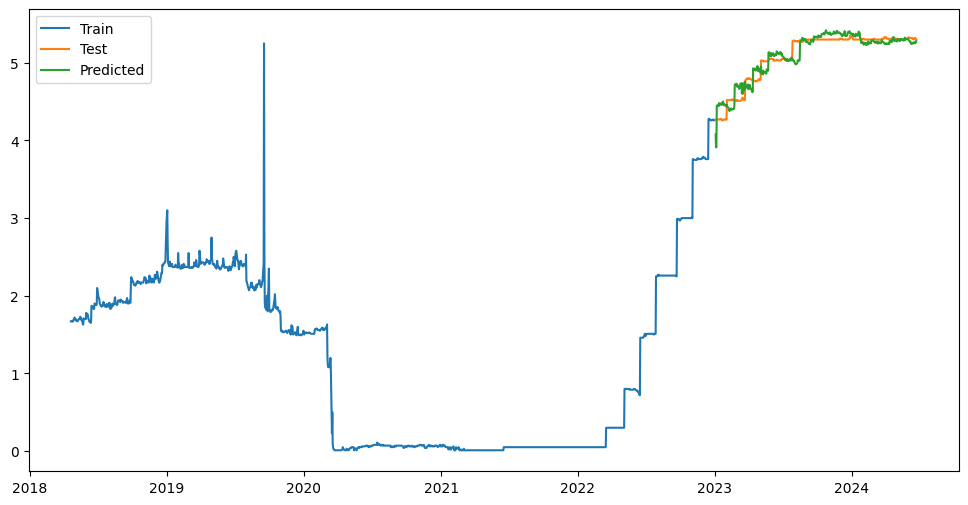

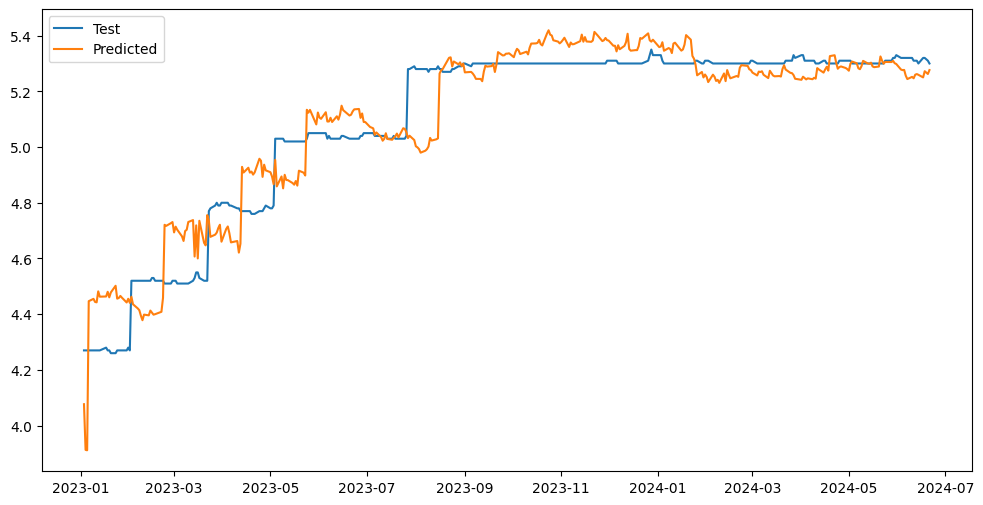

Mean Squared Error: 0.0118
Mean Absolute Error: 0.0831
R2 Score: 0.887
Root Mean Squared Error: 0.1085
Adj R2 Score: 0.8809


In [440]:
# Predict using the test set
y_pred_v6 = model_v6_fit.predict(start=len(y_train_v6), end=len(y_train_v6) + len(y_test_v6) - 1, exog=X_test_v6_scaled)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_train_v6.index, y_train_v6, label='Train')
plt.plot(y_test_v6.index, y_test_v6, label='Test')
plt.plot(y_test_v6.index, y_pred_v6, label='Predicted')
plt.legend()
plt.show()

print("\n\n")

plt.figure(figsize=(12, 6))
plt.plot(y_test_v6.index, y_test_v6, label='Test')
plt.plot(y_test_v6.index, y_pred_v6, label='Predicted')
plt.legend()
plt.show()

# Calculate mean squared error
mse = mean_squared_error(y_test_v6, y_pred_v6)
mae = mean_absolute_error(y_test_v6, y_pred_v6)
rsquare = r2_score(y_test_v6, y_pred_v6)
n = len(y_test_v6) # number of rows/observations
k = len(X_test_v6_scaled[0]) # number of independent variables/features
rmse = np.sqrt(mse)
arsquare = 1 - (1 - rsquare) * ((n - 1) / (n - k - 1))

# Print the evaluation metrics
print(f'Mean Squared Error: {round(mse,4)}')
print(f'Mean Absolute Error: {round(mae,4)}')
print(f'R2 Score: {round(rsquare,4)}')
print(f'Root Mean Squared Error: {round(rmse,4)}')
print(f'Adj R2 Score: {round(arsquare,4)}')

## Integrating GARCH

In [441]:
! pip -q install arch

from arch import arch_model

In [442]:
residuals = model_v6_fit.resid

garch_model = arch_model(residuals, vol='Garch', p=1, q=1)  # GARCH(1, 1) model
garch_result = garch_model.fit()

# Print summary
print(garch_result.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: -842.1247524374286
Optimization terminated successfully    (Exit mode 0)
            Current function value: -842.1247594740062
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                842.125
Distribution:                  Normal   AIC:                          -1676.25
Method:            Maximum Likelihood   BIC:                          -1656.01
                                        No. Observations:                 1165
Date:                Sun, Aug 18 2024   Df Residuals:                     1164
Time:                        04:27:28   Df Model:                            1
         

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04269. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [443]:
# Forecasting with SARIMAX
sarimax_forecast = model_v6_fit.get_forecast(steps=len(y_test_v6), exog=X_test_v6_scaled)
sarimax_forecast_mean = pd.DataFrame(sarimax_forecast.predicted_mean)
sarimax_forecast_conf_int = sarimax_forecast.conf_int()

sarimax_forecast_mean.reset_index(inplace=True)
sarimax_forecast_mean = sarimax_forecast_mean.drop(columns=['index'])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [444]:
# Forecasting volatility with GARCH
garch_forecast = garch_result.forecast(horizon=len(y_test_v6))
garch_forecast_variance = garch_forecast.variance

# Preparing output for plotting
garch_forecast_variance.reset_index(inplace=True)
garch_forecast_variance = garch_forecast_variance.drop(columns=['Date'])
garch_forecast_variance['garch_forecast_variance'] = 'Garch Forecast Variance'
cols = garch_forecast_variance.columns.to_list()
cols.sort()
garch_forecast_variance = garch_forecast_variance[cols]
garch_forecast_variance = pd.DataFrame.transpose(garch_forecast_variance)
garch_forecast_variance.reset_index(inplace=True)
garch_forecast_variance.columns = garch_forecast_variance.iloc[0]
garch_forecast_variance = garch_forecast_variance[1:]
garch_forecast_variance.drop(columns=['garch_forecast_variance'], inplace=True)
garch_forecast_variance.reset_index(inplace=True)
garch_forecast_variance.drop(columns=['index'], inplace=True)
garch_forecast_variance['Garch Forecast Variance'] = garch_forecast_variance['Garch Forecast Variance'].astype(float)

In [445]:
# Preparing Dates for Plotting
test_dates = y_test_v6.reset_index()
test_dates.drop(columns=['Rate (%)'], inplace=True)

In [446]:
# Creating Dataframe for Plotting
forecast_df = pd.concat([test_dates, sarimax_forecast_mean, garch_forecast_variance], axis=1)
forecast_df.set_index('Date', inplace=True)
forecast_df['+2 Std. Dev.'] = forecast_df['predicted_mean'] + 2 * forecast_df['Garch Forecast Variance']
forecast_df['-2 Std. Dev.'] = forecast_df['predicted_mean'] - 2 * forecast_df['Garch Forecast Variance']

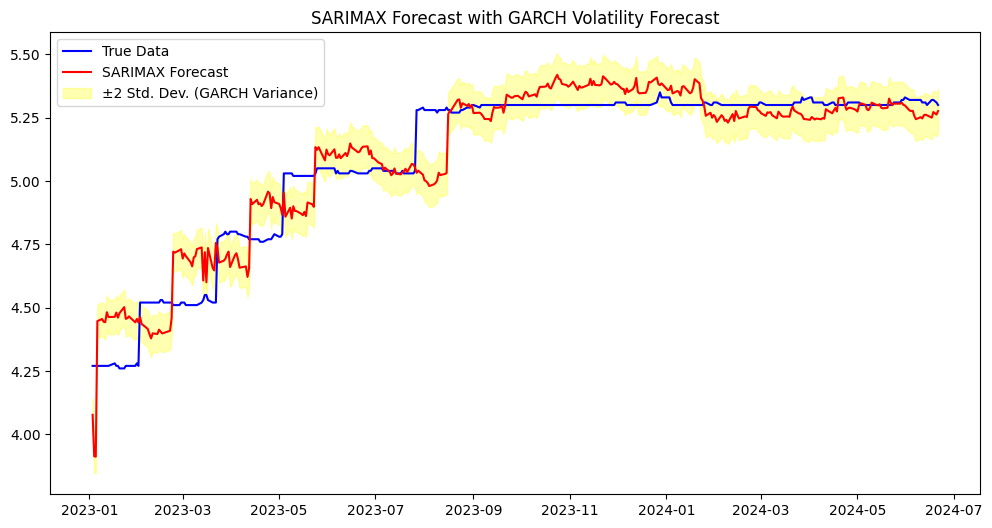

In [447]:
plt.figure(figsize=(12, 6))

# Plot SARIMAX forecast
plt.plot(y_test_v6.index, y_test_v6, label='True Data', color='blue')
plt.plot(y_test_v6.index, sarimax_forecast_mean, label='SARIMAX Forecast', color='red')

# Plot GARCH forecast variance
plt.fill_between(y_test_v6.index,
                 forecast_df['+2 Std. Dev.'],
                 forecast_df['-2 Std. Dev.'],
                 color='yellow', alpha=0.3, label='±2 Std. Dev. (GARCH Variance)')

plt.legend()
plt.title('SARIMAX Forecast with GARCH Volatility Forecast')
plt.show()

## Feature Importance

In [448]:
feature_names = X_train_v6.columns.to_list()

# Extract the parameter names from the SARIMAX results
params = pd.read_html(model_v6_fit.summary().tables[1].as_html(), header=0, index_col=0)[0].index.tolist()

# Create a list of the coefficient names (assuming the pattern x1, x2, ..., xN)
coefficient_names = [f'x{i}' for i in range(1, len(params) + 1)]

# Map the coefficient names to the original feature names
mapping = {coef: name for coef, name in zip(coefficient_names, feature_names)}

# Create a DataFrame to visualize the mapping
mapping_df = pd.DataFrame(list(mapping.items()), columns=['Coefficient', 'Feature Name'])

<ipython-input-448-07d2c5329d0f>:4: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  params = pd.read_html(model_v6_fit.summary().tables[1].as_html(), header=0, index_col=0)[0].index.tolist()


In [449]:
summary_df = pd.DataFrame(pd.read_html(model_v6_fit.summary().tables[1].as_html(), header=0, index_col=0)[0])

<ipython-input-449-d9867399340c>:1: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  summary_df = pd.DataFrame(pd.read_html(model_v6_fit.summary().tables[1].as_html(), header=0, index_col=0)[0])


In [469]:
feature_df_final = pd.merge(mapping_df, summary_df, left_on='Coefficient', right_index=True, how='right')
feature_df_final['Feature'] = feature_df_final['Feature Name'].fillna(feature_df_final['Coefficient'])
feature_df_final = feature_df_final.drop(columns=['Feature Name', 'Coefficient'])
feature_df_final.reset_index(inplace=True)
feature_df_final.drop(columns=['index'], inplace=True)
feature_df_final = feature_df_final[['Feature', 'coef', 'std err', 'z', 'P>|z|', '[0.025', '0.975]']]
feature_df_final

,Feature,coef,std err,z,P>|z|,[0.025,0.975]
0,Day,0.0166,0.039,0.429,0.668,-0.059,0.092
1,Yield Spread (4W - 52W) - First Differenced,0.9706,0.422,2.299,0.022,0.143,1.798
2,Yield Spread (13W - 52W) - First Differenced,0.0067,0.094,0.072,0.943,-0.177,0.190
3,Yield Spread (20Y - 4W) - First Differenced,-1.3031,0.550,-2.370,0.018,-2.381,-0.225
4,Yield Spread (20Y - 52W) - First Differenced,0.9907,0.401,2.469,0.014,0.204,1.777
5,NASDAQ - First Differenced,0.0262,0.036,0.719,0.472,-0.045,0.098
6,13 WEEKS COUPON EQUIVALENT - Second Differenced,0.0502,0.083,0.603,0.547,-0.113,0.214
7,26 WEEKS COUPON EQUIVALENT - Second Differenced,-0.0928,0.083,-1.119,0.263,-0.255,0.070
8,Month - Lag14,0.0875,0.048,1.827,0.068,-0.006,0.181
9,Day - Lag1,-0.0111,0.043,-0.260,0.795,-0.094,0.072


In [451]:
! pip -q install great-tables

from great_tables import GT, style, loc, md

In [467]:
# Significant Features
significant_features = feature_df_final.sort_values(by='coef', ascending=False, inplace=True, key= abs)
significant_features = feature_df_final[feature_df_final['P>|z|'] < 0.05]

GT(significant_features)\
.tab_header(title= md("**SIGNIFICANT FEATURES**"), subtitle= md("*Features with p-values less than 5%*"))\
.fmt_number(columns=['coef', 'std err', 'z', 'P>|z|', '[0.025', '0.975]'], compact=True)\
.tab_options(table_width= "1200px", heading_background_color= 'lightblue', column_labels_font_weight= "bold", heading_title_font_weight= "bold")\
.opt_table_outline(style= "solid", width= "1px", color= "grey")

GT(_tbl_data=                                              Feature    coef  std err  \
17                                   Rate (%) - Lag14  5.2293    0.071   
3         Yield Spread (20Y - 4W) - First Differenced -1.3031    0.550   
4        Yield Spread (20Y - 52W) - First Differenced  0.9907    0.401   
1         Yield Spread (4W - 52W) - First Differenced  0.9706    0.422   
14  UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUN... -0.5755    0.165   
19                                              ma.L1  0.5638    0.008   
15  CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  - ... -0.2567    0.117   
18                                    WSHOSHO - Lag14  0.1557    0.053   
20                                           ar.S.L12 -0.0865    0.033   
21                                             sigma2  0.0426    0.001   

         z  P>|z|  [0.025  0.975]  
17  73.913  0.000   5.091   5.368  
3   -2.370  0.018  -2.381  -0.225  
4    2.469  0.014   0.204   1.777  
1    2.299  0.022   0.143   1.798  
14  -3.492  0.000  -0.898  -0.252  
19  70.131  0.000   0.548   0.580  
15  -2.203  0.028  -0.485  -0.028  
18   2.966  0.003   0.053   0.259  
20  -2.630  0.009  -0.151  -0.022  
21  83.146  0.000   0.042   0.044  , _body=<great_tables._gt_data.Body object at 0x783cab25d2a0>, _boxhead=Boxhead([ColInfo(var='Feature', type=<ColInfoTypeEnum.default: 1>, column_label='Feature', column_align='left', column_width=None), ColInfo(var='coef', type=<ColInfoTypeEnum.default: 1>, column_label='coef', column_align='right', column_width=None), ColInfo(var='std err', type=<ColInfoTypeEnum.default: 1>, column_label='std err', column_align='right', column_width=None), ColInfo(var='z', type=<ColInfoTypeEnum.default: 1>, column_label='z', column_align='right', column_width=None), ColInfo(var='P>|z|', type=<ColInfoTypeEnum.default: 1>, column_label='P>|z|', column_align='right', column_width=None), ColInfo(var='[0.025', type=<ColInfoTypeEnum.default: 1>, column_label='[0.025', column_align='right', column_width=None), ColInfo(var='0.975]', type=<ColInfoTypeEnum.default: 1>, column_label='0.975]', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x783cac09c580>, _spanners=Spanners([]), _heading=Heading(title=Md(text='**SIGNIFICANT FEATURES**'), subtitle=Md(text='*Features with p-values less than 5%*'), preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x783cab25d0c0>, _formats=[<great_tables._gt_data.FormatInfo object at 0x783cab25fc70>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='1200px'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top

In [453]:
# Summary Table
summary_table = pd.DataFrame({
    "Order" : [1, 2, 3, 4, 5, 6],
    "Model" : ["ARIMAX with Initial Features", "ARIMAX with CPI/PPI/Unemployment", "SARIMAX", "SARIMAX with Lag/Difference Features", "SARIMAX with Lag/Difference Features VIF", "SARIMAX with RRP/Fed Holdings/Rate Probabilities"],
    "Model AIC" : [13813611.699, 25562411.665, -1284.048, -1364.716, -1968.154, -323.680],
    "Model BIC" : [13813718.237, 25562528.350, -1162.412, -712.469, -1861.938, -212.349],
    "Test MSE" : [0.2245, 0.1956, 0.0144, 1.4463, 0.1347, 0.0118],
    "Test MAE" : [0.4356, 0.4038, 0.0881, 1.0851, 0.3214, 0.0831],
    "Test RMSE" : [0.4738, 0.4423, 0.1198, 1.2026, 0.3671, 0.1085],
    "Test R Squared" : [-1.1521, -0.8758, 0.8624, -12.8677, -0.2919, 0.8871],
    "Test Adjusted R Squared" : [-1.2634, -0.9842, 0.8544, -19.8015, -0.3433, 0.8809]
})

GT(summary_table)\
.tab_header(title= md("**SUMMARY TABLE**"), subtitle= md("*Summary Output for All SARIMAX Models*"))\
.fmt_number(columns=['Model AIC', 'Model BIC', 'Test MSE', 'Test MAE', 'Test RMSE', 'Test R Squared', 'Test Adjusted R Squared'], compact=True)\
.tab_style(style= style.text(align= 'left'), locations= loc.body(columns= ['Order']))\
.tab_style(style= style.fill(color= 'lightgreen'), locations= loc.body(rows= [5]))\
.tab_style(style= style.text(weight= "bold"), locations= loc.body(rows= [5]))\
.tab_options(heading_background_color= 'lightblue', column_labels_font_weight= "bold", heading_title_font_weight= "bold")\
.opt_table_outline(style= "solid", width= "1px", color= "grey")


GT(_tbl_data=   Order                                             Model     Model AIC  \
0      1                      ARIMAX with Initial Features  1.381361e+07   
1      2                  ARIMAX with CPI/PPI/Unemployment  2.556241e+07   
2      3                                           SARIMAX -1.284048e+03   
3      4              SARIMAX with Lag/Difference Features -1.389563e+03   
4      5          SARIMAX with Lag/Difference Features VIF -1.968154e+03   
5      6  SARIMAX with RRP/Fed Holdings/Rate Probabilities -3.236800e+02   

      Model BIC  Test MSE  Test MAE  Test RMSE  Test R Squared  \
0  1.381372e+07    0.2245    0.4356     0.4738         -1.1521   
1  2.556253e+07    0.1956    0.4038     0.4423         -0.8758   
2 -1.162412e+03    0.0144    0.0881     0.1198          0.8624   
3 -1.258147e+03    2.9379    1.3682     1.7140        -27.1686   
4 -1.861938e+03    0.1347    0.3214     0.3671         -0.2919   
5 -2.123490e+02    0.0118    0.0831     0.1085          0.8871   

   Test Adjusted R Squared  
0                  -1.2634  
1                  -0.9842  
2                   0.8544  
3                 -28.7110  
4                  -0.3433  
5                   0.8809  , _body=<great_tables._gt_data.Body object at 0x783cab4fe920>, _boxhead=Boxhead([ColInfo(var='Order', type=<ColInfoTypeEnum.default: 1>, column_label='Order', column_align='right', column_width=None), ColInfo(var='Model', type=<ColInfoTypeEnum.default: 1>, column_label='Model', column_align='left', column_width=None), ColInfo(var='Model AIC', type=<ColInfoTypeEnum.default: 1>, column_label='Model AIC', column_align='right', column_width=None), ColInfo(var='Model BIC', type=<ColInfoTypeEnum.default: 1>, column_label='Model BIC', column_align='right', column_width=None), ColInfo(var='Test MSE', type=<ColInfoTypeEnum.default: 1>, column_label='Test MSE', column_align='right', column_width=None), ColInfo(var='Test MAE', type=<ColInfoTypeEnum.default: 1>, column_label='Test MAE', column_align='right', column_width=None), ColInfo(var='Test RMSE', type=<ColInfoTypeEnum.default: 1>, column_label='Test RMSE', column_align='right', column_width=None), ColInfo(var='Test R Squared', type=<ColInfoTypeEnum.default: 1>, column_label='Test R Squared', column_align='right', column_width=None), ColInfo(var='Test Adjusted R Squared', type=<ColInfoTypeEnum.default: 1>, column_label='Test Adjusted R Squared', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x783cab3d1870>, _spanners=Spanners([]), _heading=Heading(title=Md(text='**SUMMARY TABLE**'), subtitle=Md(text='*Summary Output for All SARIMAX Models*'), preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname='data', locnum=5, grpname=None, colname='Order', rownum=0, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align='left', v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname='data', locnum=5, grpname=None, colname='Order', rownum=1, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align='left', v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname='data', locnum=5, grpname=None, colname='Order', rownum=2, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align='left', v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname='data', locnum=5, grpname=None, colname='Order', rownum=3, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align='left', v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname='data', locnum=5, grpname=None, colname='Order', rownum=4, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align='left', v_align=None, style=None, weight=None, stretch=

In [454]:
# Experimentation Table
trial_table = pd.DataFrame({
    "Order" : ['0,0,0', '1,0,0', '0,1,0', '0,0,1', '0,0,0', '0,0,0', '0,0,0', '1,0,0', '1,0,0', '1,0,0', '0,1,0', '0,1,0', '0,1,0', '0,0,1', '0,0,1', '0,0,1'],
    "Seasonal Order" : ['0,0,0,12', '0,0,0,12', '0,0,0,12', '0,0,0,12', '1,0,0,12', '0,1,0,12', '0,0,1,12', '1,0,0,12', '0,1,0,12', '0,0,1,12', '1,0,0,12', '0,1,0,12', '0,0,1,12', '1,0,0,12', '0,0,1,12', '1,0,1,12'],
    "Test MSE" : [0.0279, 11.4386, 0.6752, 0.0135, 0.0408, 0.6663, 0.0412, 8.6272, 0.4613, 11.2447, 0.6984, 78.9525, 0.6989, 0.0118, 0.0118, 0.0119],
    "Test MAE" : [0.1451, 3.2664, 0.7807, 0.0895, 0.1805, 0.7713, 0.1814, 2.8494, 0.6348, 3.2243, 0.7953, 7.6582, 0.7956, 0.0831, 0.0833, 0.0837],
    "Test RMSE" : [0.1671, 3.3821, 0.8217, 0.1162, 0.2021, 0.8162, 0.2031, 2.9372, 0.6792, 3.3533, 0.8357, 8.8855, 0.836, 0.1085, 0.1087, 0.1092],
    "Test R Squared" : [0.7323, -108.6746, -5.4738, 0.8706, 0.6083, -5.3882, 0.6047, -81.7186, -3.4227, -106.8159, -5.6968, -756.0057, -5.7013, 0.887, 0.8868, 0.8857],
    "Test Adjusted R Squared" : [0.7176, -114.6799, -5.8283, 0.8635, 0.5869, -5.738, 0.583, -86.2479, -3.6648, -112.7193, -6.0634, -797.4555, -6.0683, 0.8809, 0.8806, 0.8794]
})

GT(trial_table)\
.tab_header(title= md("**EXPERIMENTATION TABLE**"), subtitle= md("*Summary for All Combinations of Hyper-Parameters for Model 6*"))\
.fmt_number(columns=['Test MSE', 'Test MAE', 'Test RMSE', 'Test R Squared', 'Test Adjusted R Squared'], decimals= 3)\
.tab_style(style= style.fill(color= 'lightgreen'), locations= loc.body(rows= [13]))\
.tab_style(style= style.text(weight= "bold"), locations= loc.body(rows= [13]))\
.tab_options(table_width= "1200px", heading_background_color= 'lightblue', column_labels_font_weight= "bold", heading_title_font_weight= "bold")\
.opt_table_outline(style= "solid", width= "1px", color= "grey")\
.cols_align(align= 'center')


GT(_tbl_data=    Order Seasonal Order  Test MSE  Test MAE  Test RMSE  Test R Squared  \
0   0,0,0       0,0,0,12    0.0279    0.1451     0.1671          0.7323   
1   1,0,0       0,0,0,12   11.4386    3.2664     3.3821       -108.6746   
2   0,1,0       0,0,0,12    0.6752    0.7807     0.8217         -5.4738   
3   0,0,1       0,0,0,12    0.0135    0.0895     0.1162          0.8706   
4   0,0,0       1,0,0,12    0.0408    0.1805     0.2021          0.6083   
5   0,0,0       0,1,0,12    0.6663    0.7713     0.8162         -5.3882   
6   0,0,0       0,0,1,12    0.0412    0.1814     0.2031          0.6047   
7   1,0,0       1,0,0,12    8.6272    2.8494     2.9372        -81.7186   
8   1,0,0       0,1,0,12    0.4613    0.6348     0.6792         -3.4227   
9   1,0,0       0,0,1,12   11.2447    3.2243     3.3533       -106.8159   
10  0,1,0       1,0,0,12    0.6984    0.7953     0.8357         -5.6968   
11  0,1,0       0,1,0,12   78.9525    7.6582     8.8855       -756.0057   
12  0,1,0       0,0,1,12    0.6989    0.7956     0.8360         -5.7013   
13  0,0,1       1,0,0,12    0.0118    0.0831     0.1085          0.8870   
14  0,0,1       0,0,1,12    0.0118    0.0833     0.1087          0.8868   
15  0,0,1       1,0,1,12    0.0119    0.0837     0.1092          0.8857   

    Test Adjusted R Squared  
0                    0.7176  
1                 -114.6799  
2                   -5.8283  
3                    0.8635  
4                    0.5869  
5                   -5.7380  
6                    0.5830  
7                  -86.2479  
8                   -3.6648  
9                 -112.7193  
10                  -6.0634  
11                -797.4555  
12                  -6.0683  
13                   0.8809  
14                   0.8806  
15                   0.8794  , _body=<great_tables._gt_data.Body object at 0x783cb44b8370>, _boxhead=Boxhead([ColInfo(var='Order', type=<ColInfoTypeEnum.default: 1>, column_label='Order', column_align='center', column_width=None), ColInfo(var='Seasonal Order', type=<ColInfoTypeEnum.default: 1>, column_label='Seasonal Order', column_align='center', column_width=None), ColInfo(var='Test MSE', type=<ColInfoTypeEnum.default: 1>, column_label='Test MSE', column_align='center', column_width=None), ColInfo(var='Test MAE', type=<ColInfoTypeEnum.default: 1>, column_label='Test MAE', column_align='center', column_width=None), ColInfo(var='Test RMSE', type=<ColInfoTypeEnum.default: 1>, column_label='Test RMSE', column_align='center', column_width=None), ColInfo(var='Test R Squared', type=<ColInfoTypeEnum.default: 1>, column_label='Test R Squared', column_align='center', column_width=None), ColInfo(var='Test Adjusted R Squared', type=<ColInfoTypeEnum.default: 1>, column_label='Test Adjusted R Squared', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x783cab1bb0d0>, _spanners=Spanners([]), _heading=Heading(title=Md(text='**EXPERIMENTATION TABLE**'), subtitle=Md(text='*Summary for All Combinations of Hyper-Parameters for Model 6*'), preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname='data', locnum=5, grpname=None, colname='Order', rownum=13, colnum=None, styles=[CellStyleFill(color='lightgreen')]), StyleInfo(locname='data', locnum=5, grpname=None, colname='Seasonal Order', rownum=13, colnum=None, styles=[CellStyleFill(color='lightgreen')]), StyleInfo(locname='data', locnum=5, grpname=None, colname='Test MSE', rownum=13, colnum=None, styles=[CellStyleFill(color='lightgreen')]), StyleInfo(locname='data', locnum=5, grpname=None, colname='Test MAE', rownum=13, colnum=None, styles=[CellStyleFill(color='lightgreen')]), StyleInfo(locname='data', locnum=5, grpname=None, colname='Test RMSE', rownum=13, colnum=None, styles=[CellStyleFill(color='lightgreen')]), StyleInfo(locname='data', locnum=5, grpname=None, colname='Test R Squared', rownum=13, colnum=None, styles=[CellStyleFill(color='lightgreen')]), StyleInfo(locname='data', locnu

In [464]:
sarimax_sigma = pd.DataFrame(pd.read_html(model_v3_fit.summary().tables[1].as_html(), header=0, index_col=0)[0])
sarimax_sigma.reset_index(inplace=True)
sarimax_sigma.rename(columns={'index': 'Feature'}, inplace=True)

GT(sarimax_sigma)\
.tab_header(title= md("**ARIMAX SUMMARY OUTPUT**"), subtitle= md("*Summary Output for SARIMAX Model 3*"))\
.fmt_number(columns=['Test MSE', 'Test MAE', 'Test RMSE', 'Test R Squared', 'Test Adjusted R Squared'], decimals= 3)\
.tab_style(style= style.fill(color= 'lightgreen'), locations= loc.body(rows= [23]))\
.tab_style(style= style.text(weight= "bold"), locations= loc.body(rows= [23]))\
.tab_options(table_width= "1200px", heading_background_color= 'lightblue', column_labels_font_weight= "bold", heading_title_font_weight= "bold")\
.opt_table_outline(style= "solid", width= "1px", color= "grey")\
.cols_align(align= 'center')

<ipython-input-464-e860103c75bc>:1: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  sarimax_sigma = pd.DataFrame(pd.read_html(model_v3_fit.summary().tables[1].as_html(), header=0, index_col=0)[0])


GT(_tbl_data=     Feature    coef  std err      z  P>|z|  [0.025  0.975]
0         x1  0.1653    0.163  1.016  0.309  -0.153   0.484
1         x2  0.3812    1.205  0.316  0.752  -1.981   2.743
2         x3  1.2935    0.968  1.337  0.181  -0.603   3.190
3         x4 -0.2177    0.215 -1.013  0.311  -0.639   0.204
4         x5 -0.1451    0.371 -0.391  0.696  -0.873   0.583
5         x6  0.0842    0.324  0.260  0.795  -0.550   0.719
6         x7 -0.9604    1.117 -0.860  0.390  -3.150   1.229
7         x8  0.1360    1.208  0.113  0.910  -2.232   2.504
8         x9 -0.7301    1.033 -0.707  0.480  -2.755   1.295
9        x10  0.2994    1.226  0.244  0.807  -2.104   2.702
10       x11 -0.4584    2.688 -0.171  0.865  -5.728   4.811
11       x12 -1.3273    4.378 -0.303  0.762  -9.908   7.253
12       x13  0.3293    2.652  0.124  0.901  -4.868   5.527
13       x14  1.0177    2.083  0.489  0.625  -3.065   5.100
14       x15  0.1858    0.633  0.293  0.769  -1.056   1.427
15       x16  0.0642    0.480  0.134  0.894  -0.876   1.005
16       x17  0.4225    0.494  0.856  0.392  -0.545   1.390
17       x18 -0.2995    0.456 -0.657  0.511  -1.193   0.593
18       x19 -0.5165    2.538 -0.204  0.839  -5.491   4.458
19       x20 -0.0561    1.508 -0.037  0.970  -3.012   2.900
20   ar.S.L6 -0.9500    1.170 -0.812  0.417  -3.244   1.344
21   ma.S.L6 -0.0514    1.209 -0.043  0.966  -2.420   2.317
22  ma.S.L12 -0.9474    1.319 -0.718  0.473  -3.533   1.638
23    sigma2  0.0183    0.008  2.257  0.024   0.002   0.034, _body=<great_tables._gt_data.Body object at 0x783cab27e320>, _boxhead=Boxhead([ColInfo(var='Feature', type=<ColInfoTypeEnum.default: 1>, column_label='Feature', column_align='center', column_width=None), ColInfo(var='coef', type=<ColInfoTypeEnum.default: 1>, column_label='coef', column_align='center', column_width=None), ColInfo(var='std err', type=<ColInfoTypeEnum.default: 1>, column_label='std err', column_align='center', column_width=None), ColInfo(var='z', type=<ColInfoTypeEnum.default: 1>, column_label='z', column_align='center', column_width=None), ColInfo(var='P>|z|', type=<ColInfoTypeEnum.default: 1>, column_label='P>|z|', column_align='center', column_width=None), ColInfo(var='[0.025', type=<ColInfoTypeEnum.default: 1>, column_label='[0.025', column_align='center', column_width=None), ColInfo(var='0.975]', type=<ColInfoTypeEnum.default: 1>, column_label='0.975]', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x783cab1560e0>, _spanners=Spanners([]), _heading=Heading(title=Md(text='**ARIMAX SUMMARY OUTPUT**'), subtitle=Md(text='*Summary Output for SARIMAX Model 3*'), preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname='data', locnum=5, grpname=None, colname='Feature', rownum=23, colnum=None, styles=[CellStyleFill(color='lightgreen')]), StyleInfo(locname='data', locnum=5, grpname=None, colname='coef', rownum=23, colnum=None, styles=[CellStyleFill(color='lightgreen')]), StyleInfo(locname='data', locnum=5, grpname=None, colname='std err', rownum=23, colnum=None, styles=[CellStyleFill(color='lightgreen')]), StyleInfo(locname='data', locnum=5, grpname=None, colname='z', rownum=23, colnum=None, styles=[CellStyleFill(color='lightgreen')]), StyleInfo(locname='data', locnum=5, grpname=None, colname='P>|z|', rownum=23, colnum=None, styles=[CellStyleFill(color='lightgreen')]), StyleInfo(locname='data', locnum=5, grpname=None, colname='[0.025', rownum=23, colnum=None, styles=[CellStyleFill(color='lightgreen')]), StyleInfo(locname='data', locnum=5, grpname=None, colname='0.975]', rownum=23, colnum=None, styles=[CellStyleFill(color='lightgreen')]), StyleInfo(locname='data', locnum=5, grpname=None, colname='Feature', rownum=23, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname='data', locnum=5, grpname=None, colname

In [473]:
GT(feature_df_final)\
.tab_header(title= md("**ARIMAX SUMMARY OUTPUT**"), subtitle= md("*Summary Output for SARIMAX Model 6*"))\
.fmt_number(columns=['Model AIC', 'Model BIC', 'Test MSE', 'Test MAE', 'Test RMSE', 'Test R Squared', 'Test Adjusted R Squared'], compact=True)\
.tab_style(style= style.text(align= 'left'), locations= loc.body(columns= ['Order']))\
.tab_options(table_width= "1200px", heading_background_color= 'lightblue', column_labels_font_weight= "bold", heading_title_font_weight= "bold")\
.opt_table_outline(style= "solid", width= "1px", color= "grey")

GT(_tbl_data=                                              Feature    coef  std err  \
0                                                 Day  0.0166    0.039   
1         Yield Spread (4W - 52W) - First Differenced  0.9706    0.422   
2        Yield Spread (13W - 52W) - First Differenced  0.0067    0.094   
3         Yield Spread (20Y - 4W) - First Differenced -1.3031    0.550   
4        Yield Spread (20Y - 52W) - First Differenced  0.9907    0.401   
5                          NASDAQ - First Differenced  0.0262    0.036   
6     13 WEEKS COUPON EQUIVALENT - Second Differenced  0.0502    0.083   
7     26 WEEKS COUPON EQUIVALENT - Second Differenced -0.0928    0.083   
8                                       Month - Lag14  0.0875    0.048   
9                                          Day - Lag1 -0.0111    0.043   
10                                         Day - Lag2 -0.0019    0.044   
11                                         Day - Lag3  0.0072    0.042   
12                                         Day - Lag7 -0.0193    0.046   
13                                        Day - Lag14 -0.0244    0.039   
14  UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUN... -0.5755    0.165   
15  CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  - ... -0.2567    0.117   
16                               Unemployment - Lag14 -0.0409    0.227   
17                                   Rate (%) - Lag14  5.2293    0.071   
18                                    WSHOSHO - Lag14  0.1557    0.053   
19                                              ma.L1  0.5638    0.008   
20                                           ar.S.L12 -0.0865    0.033   
21                                             sigma2  0.0426    0.001   

         z  P>|z|  [0.025  0.975]  
0    0.429  0.668  -0.059   0.092  
1    2.299  0.022   0.143   1.798  
2    0.072  0.943  -0.177   0.190  
3   -2.370  0.018  -2.381  -0.225  
4    2.469  0.014   0.204   1.777  
5    0.719  0.472  -0.045   0.098  
6    0.603  0.547  -0.113   0.214  
7   -1.119  0.263  -0.255   0.070  
8    1.827  0.068  -0.006   0.181  
9   -0.260  0.795  -0.094   0.072  
10  -0.043  0.966  -0.089   0.085  
11   0.170  0.865  -0.076   0.090  
12  -0.423  0.672  -0.109   0.070  
13  -0.623  0.533  -0.101   0.052  
14  -3.492  0.000  -0.898  -0.252  
15  -2.203  0.028  -0.485  -0.028  
16  -0.180  0.857  -0.486   0.405  
17  73.913  0.000   5.091   5.368  
18   2.966  0.003   0.053   0.259  
19  70.131  0.000   0.548   0.580  
20  -2.630  0.009  -0.151  -0.022  
21  83.146  0.000   0.042   0.044  , _body=<great_tables._gt_data.Body object at 0x783cabf16470>, _boxhead=Boxhead([ColInfo(var='Feature', type=<ColInfoTypeEnum.default: 1>, column_label='Feature', column_align='left', column_width=None), ColInfo(var='coef', type=<ColInfoTypeEnum.default: 1>, column_label='coef', column_align='right', column_width=None), ColInfo(var='std err', type=<ColInfoTypeEnum.default: 1>, column_label='std err', column_align='right', column_width=None), ColInfo(var='z', type=<ColInfoTypeEnum.default: 1>, column_label='z', column_align='right', column_width=None), ColInfo(var='P>|z|', type=<ColInfoTypeEnum.default: 1>, column_label='P>|z|', column_align='right', column_width=None), ColInfo(var='[0.025', type=<ColInfoTypeEnum.default: 1>, column_label='[0.025', column_align='right', column_width=None), ColInfo(var='0.975]', type=<ColInfoTypeEnum.default: 1>, column_label='0.975]', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x783cabf14cd0>, _spanners=Spanners([]), _heading=Heading(title=Md(text='**ARIMAX SUMMARY OUTPUT**'), subtitle=Md(text='*Summary Output for SARIMAX Model 6*'), preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x783cab432e90>, _formats=[<great_tables._gt_data.FormatInfo object at 0x783cab431c90>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), 

In [486]:
significant_features

,Feature,coef,std err,z,P>|z|,[0.025,0.975]
17,Rate (%) - Lag14,5.2293,0.071,73.913,0.000,5.091,5.368
3,Yield Spread (20Y - 4W) - First Differenced,-1.3031,0.550,-2.370,0.018,-2.381,-0.225
4,Yield Spread (20Y - 52W) - First Differenced,0.9907,0.401,2.469,0.014,0.204,1.777
1,Yield Spread (4W - 52W) - First Differenced,0.9706,0.422,2.299,0.022,0.143,1.798
14,"UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUN...",-0.5755,0.165,-3.492,0.000,-0.898,-0.252
19,ma.L1,0.5638,0.008,70.131,0.000,0.548,0.580
15,"CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. - ...",-0.2567,0.117,-2.203,0.028,-0.485,-0.028
18,WSHOSHO - Lag14,0.1557,0.053,2.966,0.003,0.053,0.259
20,ar.S.L12,-0.0865,0.033,-2.630,0.009,-0.151,-0.022
21,sigma2,0.0426,0.001,83.146,0.000,0.042,0.044


In [483]:
gr = sarimax_sigma = pd.DataFrame(pd.read_html(garch_result.summary().tables[2].as_html(), header=0, index_col=0)[0])

<ipython-input-483-ec761d17a8f5>:1: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  gr = sarimax_sigma = pd.DataFrame(pd.read_html(garch_result.summary().tables[2].as_html(), header=0, index_col=0)[0])


In [485]:
gr

,coef,std err,t,P>|t|,95.0% Conf. Int.
omega,0.000854,0.00030,2.841,4.495000e-03,"[2.648e-04,1.443e-03]"
alpha[1],0.200000,0.09615,2.080,3.751000e-02,"[1.156e-02, 0.388]"
beta[1],0.780000,0.04223,18.471,3.561000e-76,"[ 0.697, 0.863]"
